# Notebook Setup

In [49]:
# Install/Import All Relevant Packages

!pip -q install openpyxl

!pip -q install --upgrade statsmodels joblib tqdm

from google.colab import files
import csv
import requests
import pandas as pd, numpy as np, statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from numpy.linalg import LinAlgError
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings, datetime as dt, re
import glob
from pathlib import Path
from urllib.parse import quote
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from pandas.plotting import parallel_coordinates
from IPython.display import display, Markdown
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg


warnings.filterwarnings("ignore", category=FutureWarning)


# Data Collection

## Company Data

FactSet was utilized for obtaining company data. FTSE Russell ESG scores for the time period 2016-2015 were downloaded for all companies, alongwith industry and sector details (9420 companies). 2134 companies had ratings for all 10 years 2016-2015, of which 811 companies were from the 5 major English-speaking markets (United States, United Kingdom, Australia, India, Singapore). Due to insufficient industry spread for Australia and Singapore, companies were selected for preliminary analysis from USA, UK and India.

2025 ESG scores are used for grouping: 5 companies each from high (<4), medium (3.5 to 3) and low (<2.5) ESG ratings were selected from each country, allowing for sufficient industry and sector distribution, for a total of 45 companies.

For each of the 45 companies, weekly stock data such as price (open, high, low), returns, volume, etc. was collected from FactSet. Of these, only the weekly returns will be used for analysis.


In [2]:
# @title
# Loading the Selected Companies ESG and Industry data (downloaded from FactSet and stored in GitHub repo)

# GitHub raw URL
url = "https://raw.githubusercontent.com/M1ck3yJ0/Research_Stock_Price_Google_Trends/main/ESG%20Selected%20Companies.csv"

# Load the CSV into a DataFrame
esg_df = pd.read_csv(url)

# Display the first few rows
esg_df.head()


,Name,Ticker,FTSE ESG Country Code,FTSE ESG Industry,FTSE ESG Super Sec,FTSE ESG Sector,FTSE ESG Subsector,FTSE ESG Exchg,FTSE ESG Rating 2025,FTSE ESG Rating 2024,FTSE ESG Rating 2023,FTSE ESG Rating 2022,FTSE ESG Rating 2021,FTSE ESG Rating 2020,Change 5 Years,Market Cap
0,Coca-Cola HBC AG,CCH,UK,Consumer Staples,"Food, Beverage and Tobacco",Beverages,Soft Drinks,XLON,4.9,4.8,4.8,4.5,4.6,4.7,0.2,Large Cap
1,Barclays PLC,BARC,UK,Financials,Banks,Banks,Banks,XLON,4.7,4.7,4.7,4.2,4.7,4.8,-0.1,Large Cap
2,Johnson & Johnson,JNJ,USA,Health Care,Health Care,Pharmaceuticals and Biotechnology,Pharmaceuticals,XNYS,4.7,4.6,4.6,4.3,4.4,4.1,0.6,Large Cap
3,Coca-Cola Europacific Partners plc,CCEP,USA,Consumer Staples,"Food, Beverage and Tobacco",Beverages,Soft Drinks,XNAS,4.6,4.4,4.6,4.4,4.7,4.6,0.0,Large Cap
4,Jupiter Fund Management plc,JUP,UK,Financials,Financial Services,Investment Banking and Brokerage Services,Asset Managers and Custodians,XLON,4.6,4.6,4.5,4.4,4.5,4.5,0.1,Small Cap


## Trends URL Generation

80 keywords that are potentially linked to company/share health and perception were selected, and Google Trends data will be downloaded for each of them comparatively for the 5 major English-speaking markets (United States, United Kingdom, Australia, India, Singapore), and then individually for Worldwide data.
The same will be done for company names stripped-down to keyword form.

In [3]:
# @title
### Regional Data ###

# Load CSV from GitHub
url = "https://raw.githubusercontent.com/M1ck3yJ0/Research_Stock_Price_Google_Trends/main/Trends_Keywords.csv"
df = pd.read_csv(url)

# Keep the keyword and its category in a DataFrame
keywords = (
    df[["Keyword", "Keyword Category"]]
      .dropna(subset=["Keyword"])            # make sure the keyword isn’t NaN
      .reset_index(drop=True)
)
keywords_df = keywords                 # alias for clarity

# list of keyword strings for URL generation
keyword_list = keywords["Keyword"].astype(str).tolist()

# Define URL components
base_url = "https://trends.google.com/trends/explore"
date_range = "2019-12-31%202025-01-01"
geo = "IN,AU,GB,US,SG"
hl = "en"

# Generate URLs
urls = []
for keyword in keyword_list:
    encoded_keyword = quote(keyword)
    repeated_keywords = ",".join([encoded_keyword] * 5)
    url = (
        f"{base_url}?date={date_range},{date_range},{date_range},{date_range},{date_range}"
        f"&geo={geo}&q={repeated_keywords}&hl={hl}"
    )
    urls.append(url)

# Save to CSV
output_df = pd.DataFrame({"Keyword": keyword_list, "URL": urls})
output_filename = "Regional_Generated_URLs.csv"
output_df.to_csv(output_filename, index=False)
# files.download(output_filename)

# Print number of URLs generated
print(f"{len(urls)} URLs generated.")


124 URLs generated.


In [4]:
# @title
### Global Data ###

# Load CSV from GitHub
url = "https://raw.githubusercontent.com/M1ck3yJ0/Research_Stock_Price_Google_Trends/main/Trends_Keywords.csv"
df = pd.read_csv(url)

# Extract valid keywords and categories
keywords_df = (
    df[["Keyword", "Keyword Category"]]
      .dropna(subset=["Keyword"])
      .reset_index(drop=True)
)

# Convert keyword column to list of strings
keyword_list = keywords_df["Keyword"].astype(str).tolist()

# Define URL components
base_url = "https://trends.google.com/trends/explore"
date_range = "2019-12-25%202025-01-10"
hl = "en"

# Generate URLs — one keyword per URL
urls = []
for keyword in keyword_list:
    encoded_keyword = quote(keyword)
    url = f"{base_url}?date={date_range}&q={encoded_keyword}&hl={hl}"
    urls.append(url)

# Save to CSV
output_df = pd.DataFrame({"Keyword": keyword_list, "URL": urls})
output_filename = "Global_Generated_URLs.csv"
output_df.to_csv(output_filename, index=False)

# Print result summary
print(f"{len(urls)} URLs generated and saved to '{output_filename}'.")


124 URLs generated and saved to 'Global_Generated_URLs.csv'.


# Data Preparation

## Stock Data Merging, Cleaning

The following cell contains code that is used to clean the bulk-downloaded stock data. There is one .xlsx workbook for each company, which consists of weekly stock data such as opening price, closing price, volume, volume change, returns, returns change, etc. Only the weekly returns are considered for analysis, since we are interested in guaging how predictive the movement in search volume is for *movement* in stock price.

The stock market "week" generally runs till Friday but can vary depending on holidays, regulatory actions, etc. So dates are normalized to follow the same pattern as the Trends week, which runs from Sunday to Saturday, for alignment in analysis.

In [5]:
# @title

# Load the Excel workbooks into /content/ - there is a separate .xlsx workbook for each company
!git clone --depth 1 https://github.com/M1ck3yJ0/Stock-Data.git /content/Stock-Data
excel_files = glob.glob("/content/Stock-Data/*.xlsx")
print(f"Found {len(excel_files)} workbooks")

# Read each .xlsx - whose real header row is the 3rd row (index-2)
def load_one(path: str) -> pd.DataFrame:
    df = pd.read_excel(path, skiprows=2, usecols=["Date", "% Return"])
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce").dt.normalize()
    df = df.dropna(subset=["Date", "% Return"]).copy()

    # push each trading date back to its Sunday (Mon=0 … Sun=6) to align with Trends Week dates which run from Sun-Sat
    dow = df["Date"].dt.weekday
    df["Week"] = (df["Date"] - pd.to_timedelta((dow + 1) % 7, unit="D")).dt.date

    # keep the last trading day of each week
    df = df.sort_values("Date").groupby("Week", as_index=False).tail(1)
    company = Path(path).stem
    return df[["Week", "% Return"]].rename(columns={"% Return": company})

frames = [load_one(p) for p in excel_files]
weekly_returns = (
    frames[0]
      .set_index("Week")
      .join([f.set_index("Week") for f in frames[1:]], how="outer")
      .sort_index()
)

weekly_returns.index.name = "Date"

weekly_returns = weekly_returns.fillna(0)

weekly_returns = weekly_returns.reset_index()

weekly_returns.to_csv("/content/stock_returns_selected_companies.csv")

print("Shape      :", weekly_returns.shape)
print("Date range :", weekly_returns.index.min(), "→", weekly_returns.index.max())
print("Missing 0s :", (weekly_returns == 0).sum().sum())
print("Saved      : /content/stock_returns_selected_companies.csv")


Cloning into '/content/Stock-Data'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 47 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (47/47), 1.64 MiB | 15.12 MiB/s, done.
Found 45 workbooks
Shape      : (263, 46)
Date range : 0 → 262
Missing 0s : 78
Saved      : /content/stock_returns_selected_companies.csv


In [6]:
# @title
# Load stock returns dataframe (cleaned and processed in prev. section)
stock_df = weekly_returns

# Convert 'Date' column to datetime
stock_df['Date'] = pd.to_datetime(stock_df['Date'], errors='coerce')

# Rename all columns (except the first "Date" column) with prefix "Stock_Returns"
stock_df.columns = ['Date'] + ['Stock_Returns_' + col for col in stock_df.columns[1:]]

# Sort by Date, oldest to newest
stock_df = stock_df.sort_values('Date', ascending=False, kind='mergesort') \
                   .reset_index(drop=True)
# Sort columns alphabetically, keeping 'Week' first
sorted_cols = ['Date'] + sorted([col for col in stock_df.columns if col != 'Date'])
stock_df = stock_df[sorted_cols]

# Check for missing values
missing_summary = stock_df.isnull().sum()

# Print info
print(stock_df.shape)
stock_df.info()
print(stock_df.head())
print("\nMissing values per column:\n", missing_summary)


(263, 46)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 46 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   Date                                                       263 non-null    datetime64[ns]
 1   Stock_Returns_Ashok Leyland Limited                        263 non-null    float64       
 2   Stock_Returns_Barclays PLC                                 263 non-null    float64       
 3   Stock_Returns_Berkshire Hathaway Inc. Class A              263 non-null    float64       
 4   Stock_Returns_Bharat Heavy Electricals Limited             263 non-null    float64       
 5   Stock_Returns_Bharat Petroleum Corporation Limited         263 non-null    float64       
 6   Stock_Returns_BioMarin Pharmaceutical Inc.                 263 non-null    float64       
 7   Stock_Returns_Chemring Gr

## Transform & Clean Trends Raw Data

Trends data is manually downloaded as individual csv files that are merged directly via Mac Terminal (command prompt) due to high volume. The resulting combined file (which is stored in GitHub and loaded into dataframe) is cleaned below.

In [7]:
# @title
# Load raw trends data from GitHub (merged csv of individual Trends csvs for each Trends term)
github_url = 'https://raw.githubusercontent.com/M1ck3yJ0/Research_Stock_Price_Google_Trends/main/trends_raw_combined.csv'
response = requests.get(github_url)
content = response.content.decode('utf-8')
lines = content.splitlines()

# Strip and split each line using CSV reader
parsed_lines = list(csv.reader(lines))

# Convert to DataFrame for processing
df = pd.DataFrame(parsed_lines)


In [8]:
# @title
### Rename & Restructure ###

trends_df = None
i = 0

while i < len(df):
    # Detect the start of a new block
    if isinstance(df.iloc[i, 0], str) and df.iloc[i, 0].startswith("Category:"):
        header_row = i + 2
        data_start = i + 3

        # Extract headers and keyword
        header = df.iloc[header_row].tolist()
        data_rows = []

        # Gather all rows until next 'Category:' or end of file
        j = data_start
        while j < len(df) and not (isinstance(df.iloc[j, 0], str) and df.iloc[j, 0].startswith("Category:")):
            data_rows.append(df.iloc[j].tolist())
            j += 1

        block_df = pd.DataFrame(data_rows, columns=header)
        block_df = block_df.dropna(how='all')  # drop completely empty rows
        block_df = block_df.reset_index(drop=True)

        # Create new column names based on "Keyword: (Region)"
        keyword_df = pd.DataFrame()
        for col in block_df.columns[1:]:  # Skip Week
            if col and ':' in col:
                keyword_part, region_part = col.split(':', 1)
                keyword = keyword_part.strip()
                region = region_part.strip(" ()")
                new_col = f"Trends {keyword} ({region})"
                keyword_df[new_col] = block_df[col]

        # Include Week
        keyword_df.insert(0, "Week", block_df["Week"])

        # Merge with master DataFrame
        if trends_df is None:
            trends_df = keyword_df
        else:
            trends_df = pd.merge(trends_df, keyword_df, on="Week", how="outer")

        # Move to next block
        i = j
    else:
        i += 1


# Sort columns alphabetically, keeping 'Week' first
sorted_cols = ['Week'] + sorted([col for col in trends_df.columns if col != 'Week'])
trends_df = trends_df[sorted_cols]

# Statistics and Preview
print("Dataset shape:", trends_df.shape)
print("\nDataset info:")
trends_df.info()
print("\nTransposed data head:")
print(trends_df.head().T)

# Save result
trends_df.to_csv("trends_transformed.csv", index=False)
print("Transformation complete — csv downloaded")
# files.download("trends_transformed.csv") # Uncomment to trigger automatic download


Dataset shape: (264, 740)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Columns: 740 entries, Week to Trends Zydus Lifesciences (Worldwide)
dtypes: object(740)
memory usage: 1.5+ MB

Transposed data head:
                                                     0           1  \
Week                                        2019-12-22  2019-12-29   
Trends AI (Australia)                              NaN           4   
Trends AI (India)                                  NaN           5   
Trends AI (Singapore)                              NaN          13   
Trends AI (United Kingdom)                         NaN           3   
...                                                ...         ...   
Trends Zydus Lifesciences (India)                  NaN           0   
Trends Zydus Lifesciences (Singapore)              NaN           0   
Trends Zydus Lifesciences (United Kingdom)         NaN           0   
Trends Zydus Lifesciences (United States)          NaN

In [9]:
# @title
### Cleaning ###

# Identify the date column
date_column = trends_df.columns[0]

# Convert the date column to datetime
trends_df[date_column] = pd.to_datetime(trends_df[date_column], errors='coerce')

# Replace "<1" with 0.5 in all columns except the date column
trends_df[trends_df.columns.difference([date_column])] = trends_df[trends_df.columns.difference([date_column])].replace("<1", 0.5)

# Convert all columns to numeric except the date column
trends_df[trends_df.columns.difference([date_column])] = trends_df[trends_df.columns.difference([date_column])].apply(pd.to_numeric, errors='coerce')

# Sort by date column, oldest to newest
trends_df = trends_df.sort_values(by=date_column).reset_index(drop=True)

# Drop first and last row (additional in Worldwide data)
trends_df = trends_df.iloc[1:-1].reset_index(drop=True)

# Check for missing values and display details
missing_positions = trends_df.isnull()

if not missing_positions.values.any():
    print("\nNo missing values detected.")
else:
    print("\nMissing values detected — listing rows and columns:")
    for row_idx, row in missing_positions.iterrows():
        for col in missing_positions.columns:
            if row[col]:
                print(f"Row {row_idx}, Column '{col}', Date: {trends_df.at[row_idx, date_column]}")

# Statistics and Preview
print("Dataset shape:", trends_df.shape)
print("\nDataset info:")
trends_df.info()
print("\nTransposed data head:")
print(trends_df.head().T)

# Save result
trends_df.to_csv("trends_cleaned.csv", index=False)
print("Cleaning complete — csv downloaded")
# files.download("trends_cleaned.csv") # Uncomment to trigger automatic download



No missing values detected.
Dataset shape: (262, 740)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Columns: 740 entries, Week to Trends Zydus Lifesciences (Worldwide)
dtypes: datetime64[ns](1), float64(616), int64(123)
memory usage: 1.5 MB

Transposed data head:
                                                              0  \
Week                                        2019-12-29 00:00:00   
Trends AI (Australia)                                       4.0   
Trends AI (India)                                           5.0   
Trends AI (Singapore)                                      13.0   
Trends AI (United Kingdom)                                  3.0   
...                                                         ...   
Trends Zydus Lifesciences (India)                           0.0   
Trends Zydus Lifesciences (Singapore)                       0.0   
Trends Zydus Lifesciences (United Kingdom)                  0.0   
Trends Zydus Lifescience

## Calculate Trends Change

To normalize data and ensure stationarity, the difference (weekly change) is considered for analysis rather than raw values. Thus we ensure uniformity in the type of data across datsets - i.e. weely change in both Trends search volumes as well as weekly stock returns.

In [10]:
# @title
# Identify the date column
date_column = trends_df.columns[0]

# Check if the date column is datetime, convert if not
if not pd.api.types.is_datetime64_any_dtype(trends_df[date_column]):
    trends_df[date_column] = pd.to_datetime(trends_df[date_column], errors='coerce')

# Sort by date column (oldest to newest)
trends_df = trends_df.sort_values(by=date_column).reset_index(drop=True)

# Calculate absolute differences for non-date columns
diff_numeric = trends_df.drop(columns=[date_column]).diff()

# Concatenate the date column back as the first column
diff_df = pd.concat([trends_df[[date_column]], diff_numeric], axis=1)

# Drop the first row (NaNs from .diff())
diff_df = diff_df.iloc[1:]

# Check for missing values
missing_summary = diff_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("\nNo missing values detected.")
else:
    print("\nColumns with missing values:")
    # turn the Series into a 2-column table for formatting
    print(missing_summary.to_frame("Nulls").to_string())

# Preview
print("Weekly differences calculated - csv downloaded")
print(diff_df.info())
print(diff_df.head())

# Save to CSV
diff_df.to_csv("trends_diff.csv", index=False)
# files.download("trends_diff.csv") # Uncomment to trigger automatic download



No missing values detected.
Weekly differences calculated - csv downloaded
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 1 to 261
Columns: 740 entries, Week to Trends Zydus Lifesciences (Worldwide)
dtypes: datetime64[ns](1), float64(739)
memory usage: 1.5 MB
None
        Week  Trends AI (Australia)  Trends AI (India)  Trends AI (Singapore)  \
1 2020-01-05                    0.0                0.0                    3.0   
2 2020-01-12                    0.0                0.0                    0.0   
3 2020-01-19                    1.0                0.0                    0.0   
4 2020-01-26                   -1.0                0.0                   -4.0   
5 2020-02-02                    0.0                0.0                    1.0   

   Trends AI (United Kingdom)  Trends AI (United States)  \
1                         1.0                        1.0   
2                         0.0                        0.0   
3                         0.0                      

## Creat Master Dataset

The processed Trends dataset and stock returns dataset are combined into one dataframe (based on date) for further analysis. To easily distinguish data, all Trends columns were previously appended with prefix "Trends" and all stock data columns with "Stock_Returns".

In [11]:
# @title
# Ensure both date columns are datetime
diff_df['Week'] = pd.to_datetime(diff_df['Week'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge on the adjusted date
master_df = pd.merge(diff_df, stock_df, left_on='Week', right_on='Date', how='inner')

# Add numeric Week_No column at the beginning
master_df.insert(0, "Week_No", range(1, len(master_df) + 1))

# Check for missing values
missing_summary = master_df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0]

if missing_summary.empty:
    print("\nNo missing values detected.")
else:
    print("\nColumns with missing values:")
    # turn the Series into a 2-column table for nicer formatting
    print(missing_summary.to_frame("Nulls").to_string())

# Check for duplicates
duplicates = master_df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")

# Ensure all dates are unique and sorted
unique_dates = master_df['Date'].is_unique
print(f"\nAll dates unique? {unique_dates}")
print("Date range:", master_df['Date'].min(), "to", master_df['Date'].max())

# Statistics and Preview
print("Dataset shape:", master_df.shape)
print("\nDataset info:")
master_df.info()
print("\nTransposed data head:")
print(master_df.head().T)

# Save to CSV
master_df.to_csv("Trends_Stock_Master_Data.csv", index=False)
print("Master dataset created - csv downloaded")
# files.download("Trends_Stock_Master_Data.csv") # Uncomment to trigger automatic download



No missing values detected.

Number of duplicate rows: 0

All dates unique? True
Date range: 2020-01-05 00:00:00 to 2024-12-29 00:00:00
Dataset shape: (261, 787)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Columns: 787 entries, Week_No to Stock_Returns_Zydus Lifesciences Limited
dtypes: datetime64[ns](2), float64(784), int64(1)
memory usage: 1.6 MB

Transposed data head:
                                                                 0  \
Week_No                                                          1   
Week                                           2020-01-05 00:00:00   
Trends AI (Australia)                                          0.0   
Trends AI (India)                                              0.0   
Trends AI (Singapore)                                          3.0   
...                                                            ...   
Stock_Returns_Tech Mahindra Limited                        0.16128   
Stock_Returns_UnitedHe

# Correlation Analysis

Correlation analysis is performed to see whether any clear contemporaneous relationships stand out between companies and Trends searches in the data. The analysis is performed with a view to uncover possible underlying patterns, which will be corroborated using AR-X & Granger testing.

## Multiple Time Periods

The first analysis is performed for multiple timeframes of 5,3,2 and 1 year, and 6 months (starting backwards from Dec 2024), for 0-5 week lags.

In [12]:
# @title
# Cache trend & stock columns
trend_cols = [c for c in master_df.columns if c.startswith('Trends ')]
stock_cols = [c for c in master_df.columns if c.startswith('Stock_Returns_')]

# Define timeframes, including a 'max' period
PERIOD_WEEKS = {
    '6 months': 26,
    '1 year':   52,
    '2 years':  104,
    '3 years':  156
}

first_wk = master_df['Week_No'].min()
last_wk = master_df['Week_No'].max()
full_span = last_wk - first_wk + 1
PERIOD_WEEKS['max'] = full_span

# Build timeframe list and pre-slice data
week_date_map = master_df.set_index('Week_No')['Week']
timeframes = []
week_slices = {}

for label, span in PERIOD_WEEKS.items():
    actual_span = min(span, full_span)
    start_wk = last_wk - actual_span + 1
    end_wk = last_wk
    timeframes.append({
        'label': label,
        'start_wk': start_wk,
        'end_wk': end_wk,
        'Date_Range': f"{week_date_map.loc[start_wk]:%Y-%m-%d} to {week_date_map.loc[end_wk]:%Y-%m-%d}"
    })
    week_slices[(start_wk, end_wk)] = master_df[
        (master_df['Week_No'] >= start_wk) &
        (master_df['Week_No'] <= end_wk)
    ].copy()

# Create ESG lookup dictionary
esg_lookup = esg_df.set_index('Name').to_dict(orient='index')

# Run correlation analysis
LAGS = [0, 1, 2, 3, 4]
results = []
skipped_constant_series = 0
std_threshold = 1e-9  # Threshold used to identify constant or near-constant series

total_companies = len(stock_cols)
for idx, stock_col in enumerate(stock_cols, start=1):
    company = stock_col.replace('Stock_Returns_', '')
    esg_data = esg_lookup.get(company)
    if esg_data is None:
        continue

    print(f"[{idx}/{total_companies}] Processing company: {company}")

    for trend_col in trend_cols:
        for lag in LAGS:
            for tf in timeframes:
                sub = week_slices[(tf['start_wk'], tf['end_wk'])].copy()
                sub['trend_lagged'] = sub[trend_col].shift(lag)
                tmp = sub[[stock_col, 'trend_lagged']].dropna()

                if len(tmp) >= 5:
                    std_stock = tmp[stock_col].std()
                    std_trend = tmp['trend_lagged'].std()

                    if std_stock > std_threshold and std_trend > std_threshold:
                        corr = np.corrcoef(tmp[stock_col], tmp['trend_lagged'])[0, 1]
                        if not np.isnan(corr):
                            results.append({
                                'Company':     company,
                                'Trend_Term':  trend_col,
                                'Lag_Weeks':   lag,
                                'Time_Period': tf['label'],
                                'Date_Range':  tf['Date_Range'],
                                'Correlation': corr,
                                **esg_data
                            })
                    else:
                        skipped_constant_series += 1

# Convert results to DataFrame and clean up trend labels
multi_tf_corr_df = pd.DataFrame(results)

multi_tf_corr_df['Trends_Region'] = multi_tf_corr_df['Trend_Term'].str.extract(r'\((.*?)\)')
multi_tf_corr_df['Trend_Term'] = (
    multi_tf_corr_df['Trend_Term']
      .str.replace(r'^Trends\s+', '', regex=True)
      .str.replace(r'\s*\(.*?\)', '', regex=True)
)

# Append keyword category
multi_tf_corr_df = (
    multi_tf_corr_df
      .merge(keywords_df, left_on="Trend_Term", right_on="Keyword", how="left")
      .rename(columns={"Keyword Category": "Keyword_Category"})
      .drop(columns=["Keyword"])
)

# Save output
multi_tf_corr_df.to_csv('multi_tf_correlation.csv', index=False)
# files.download('multi_tf_correlation.csv') # Uncomment to trigger automatic download

# Summary
print(f"\nSkipped {skipped_constant_series:,} correlation attempts due to constant or near-constant input series.")


[1/45] Processing company: Ashok Leyland Limited
[2/45] Processing company: Barclays PLC
[3/45] Processing company: Berkshire Hathaway Inc. Class A
[4/45] Processing company: Bharat Heavy Electricals Limited
[5/45] Processing company: Bharat Petroleum Corporation Limited
[6/45] Processing company: BioMarin Pharmaceutical Inc.
[7/45] Processing company: Chemring Group PLC
[8/45] Processing company: Cincinnati Financial Corporation
[9/45] Processing company: Clarkson PLC
[10/45] Processing company: Close Brothers Group plc
[11/45] Processing company: Coca-Cola Europacific Partners plc
[12/45] Processing company: Coca-Cola HBC AG
[13/45] Processing company: EasyJet plc
[14/45] Processing company: Fresnillo PLC
[15/45] Processing company: Godrej Industries Limited
[16/45] Processing company: Grainger plc
[17/45] Processing company: HP Inc.
[18/45] Processing company: Halliburton Company
[19/45] Processing company: Hewlett Packard Enterprise Co.
[20/45] Processing company: Hindustan Zinc Li

Total correlations: 751140
Strong correlations (>|0.65|): 110 (0.01%)

--- Distribution by Company (Count) ---
                                           Count  Percent
Company                                                  
Schroder Real Estate Investment Trust Ltd     12    10.91
Kier Group plc                                11    10.00
Vodafone Idea Ltd                             11    10.00
Chemring Group PLC                             7     6.36
Kingfisher Plc                                 6     5.45
Bharat Heavy Electricals Limited               5     4.55
Coca-Cola HBC AG                               5     4.55
Hewlett Packard Enterprise Co.                 5     4.55
Bharat Petroleum Corporation Limited           4     3.64
ME Group International plc                     3     2.73
Clarkson PLC                                   3     2.73
Honeywell International Inc.                   3     2.73
EasyJet plc                                    3     2.73
O'Reilly Automotive

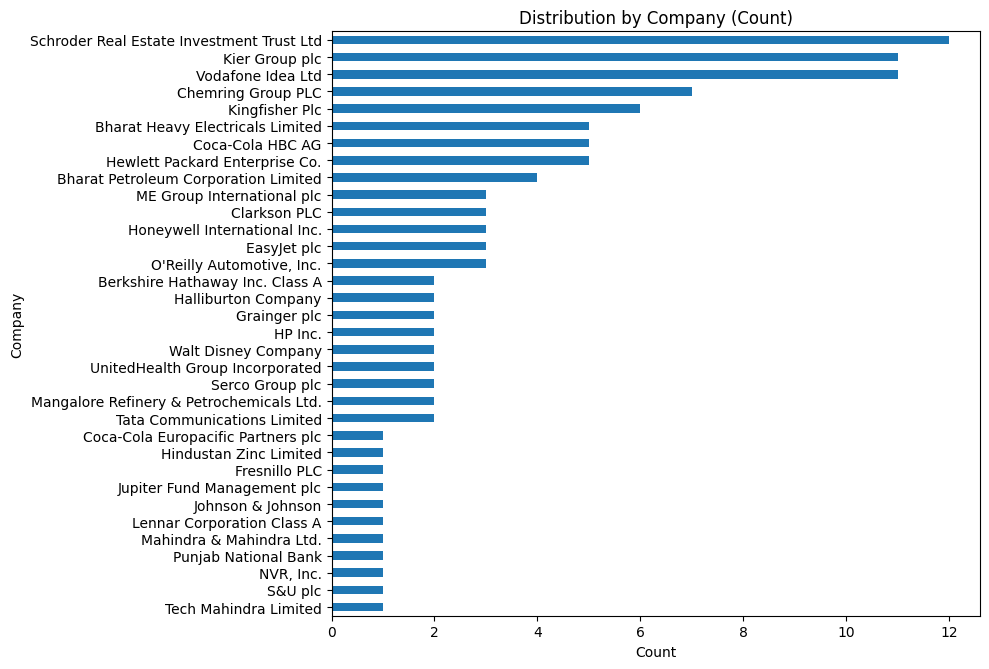


--- Distribution by Trend Term (Count) ---
                      Count  Percent
Trend_Term                          
Sustainability            4     3.64
Upgrade                   3     2.73
Ashok Leyland             3     2.73
Close Brothers Group      3     2.73
EasyJet                   3     2.73
...                     ...      ...
Innovation                1     0.91
Recovery                  1     0.91
Disruption                1     0.91
Portfolio                 1     0.91
Trade                     1     0.91

[66 rows x 2 columns]


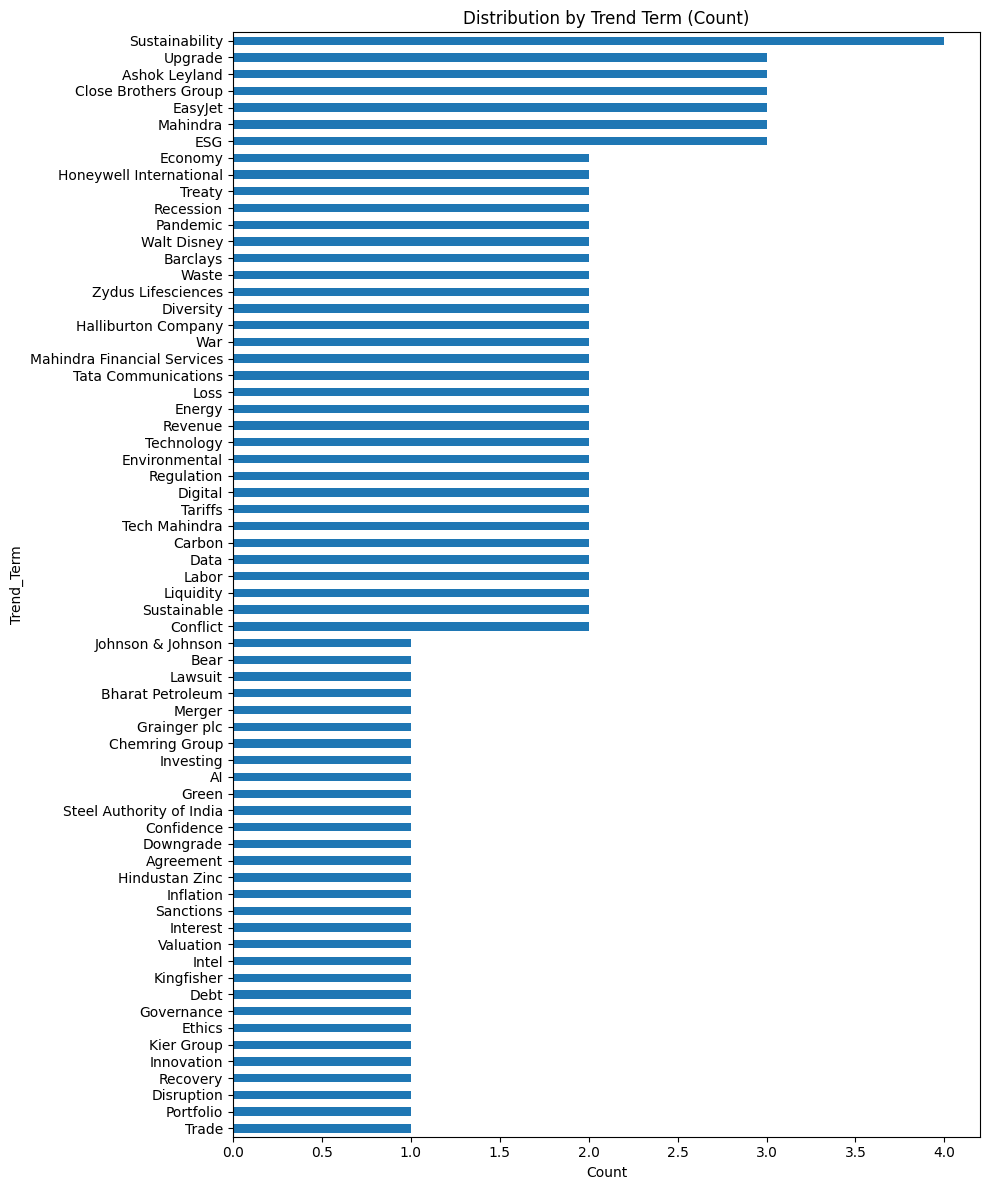


--- Distribution by Trends Region (Count) ---
                Count  Percent
Trends_Region                 
India              30    27.27
Worldwide          20    18.18
Australia          18    16.36
United Kingdom     17    15.45
United States      15    13.64
Singapore          10     9.09


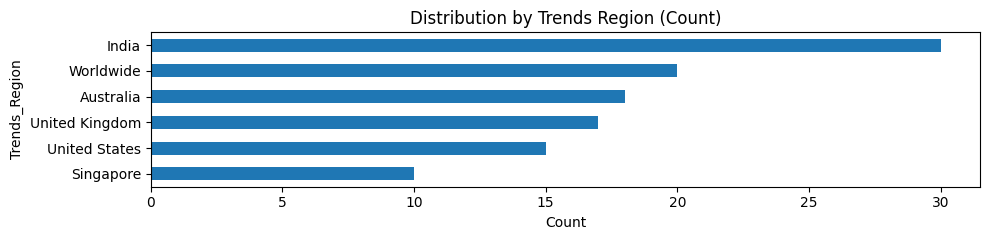


--- Distribution by Lag in Weeks (Count) ---
           Count  Percent
Lag_Weeks                
4             39    35.45
3             31    28.18
2             19    17.27
1             11    10.00
0             10     9.09


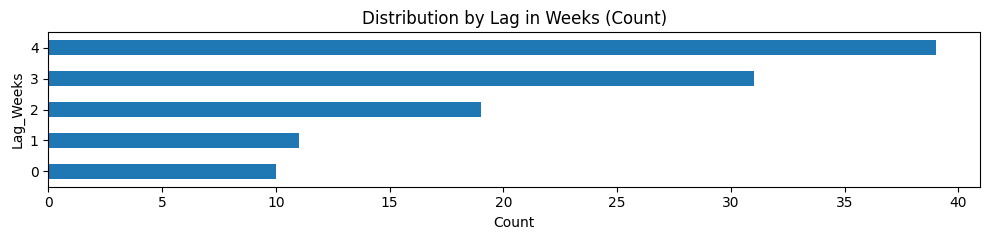


--- Distribution by Date Range (Count) ---
                          Count  Percent
Date_Range                              
2024-07-07 to 2024-12-29    107    97.27
2024-01-07 to 2024-12-29      3     2.73


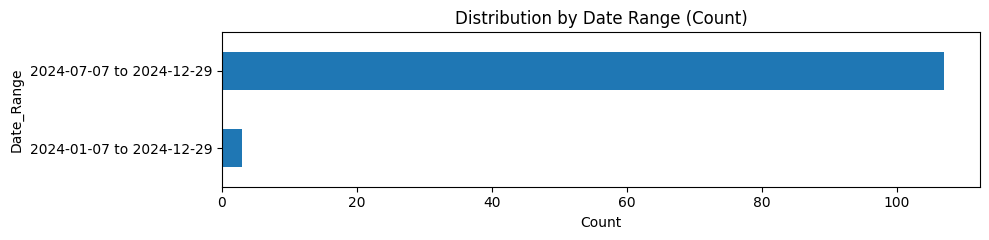


--- Distribution by ESG Rating Group (Count) ---
                  Count  Percent
ESG_Rating_Group                
Low                  45    40.91
Medium               37    33.64
High                 28    25.45


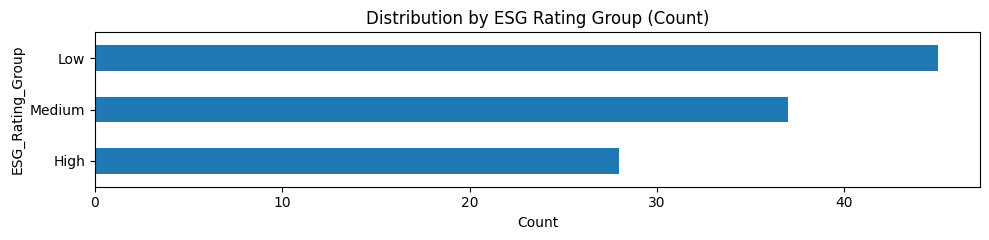


--- Distribution by Keyword Category (Count) ---
                  Count  Percent
Keyword_Category                
Company Name         37    33.64
ESG                  22    20.00
Stock                15    13.64
Industry             12    10.91
Political             9     8.18
Global                8     7.27
Economic              7     6.36


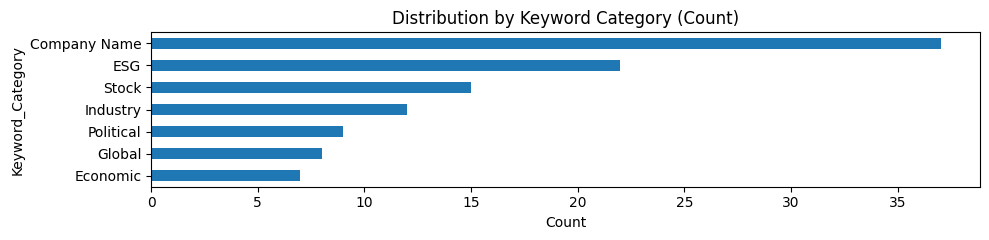


--- Distribution by Country Code (Count) ---
                       Count  Percent
FTSE ESG Country Code                
UK                        57    51.82
IND                       28    25.45
USA                       25    22.73


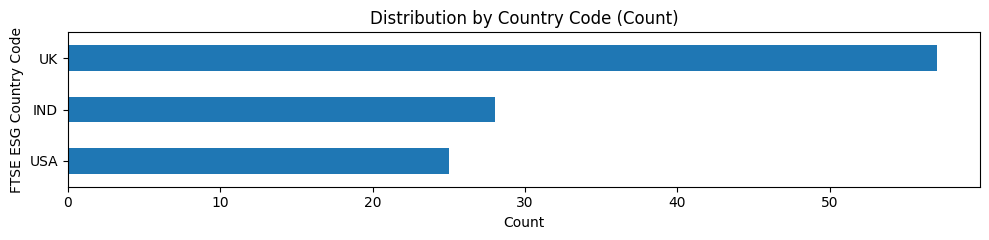


--- Distribution by Market Capitalization (Average Count per Company) ---
            Count  Percent  NumCompanies
Market Cap                              
Small Cap    3.57    22.73             7
Large Cap    2.65    55.45            23
Mid Cap      1.60    21.82            15


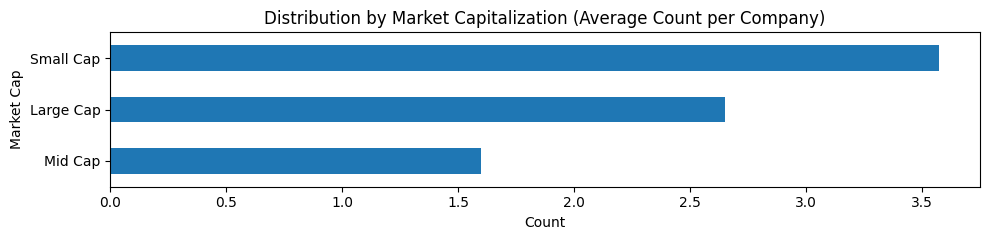


--- Distribution by Industry (Average Count per Company) ---
                        Count  Percent  NumCompanies
FTSE ESG Industry                                   
Real Estate              7.00    12.73             2
Telecommunications       6.50    11.82             2
Industrials              3.88    28.18             8
Consumer Staples         3.00     5.45             2
Energy                   2.67     7.27             3
Consumer Discretionary   2.50    18.18             8
Technology               2.00     7.27             4
Health Care              0.75     2.73             4
Basic Materials          0.67     1.82             3
Financials               0.56     4.55             9


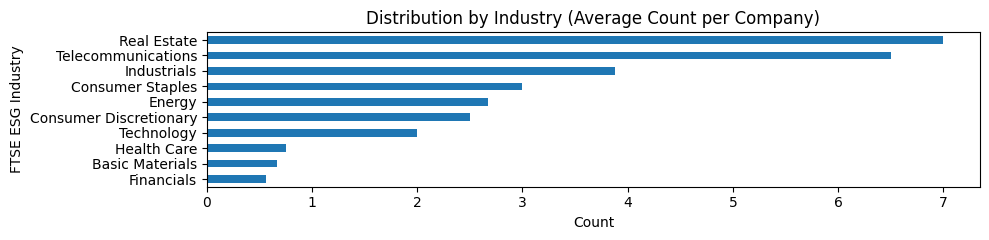


--- Distribution by Sector (Average Count per Company) ---
                                           Count  Percent  NumCompanies
FTSE ESG Sector                                                        
Real Estate Investment Trusts              12.00    10.91             1
Construction and Materials                 11.00    10.00             1
Aerospace and Defense                       7.00     6.36             1
Telecommunications Service Providers        6.50    11.82             2
Industrial Engineering                      5.00     4.55             1
Retailers                                   4.50     8.18             2
Software and Computer Services              3.00     5.45             2
Beverages                                   3.00     5.45             2
Leisure Goods                               3.00     2.73             1
Travel and Leisure                          3.00     2.73             1
Oil Gas and Coal                            2.67     7.27             3
Heal

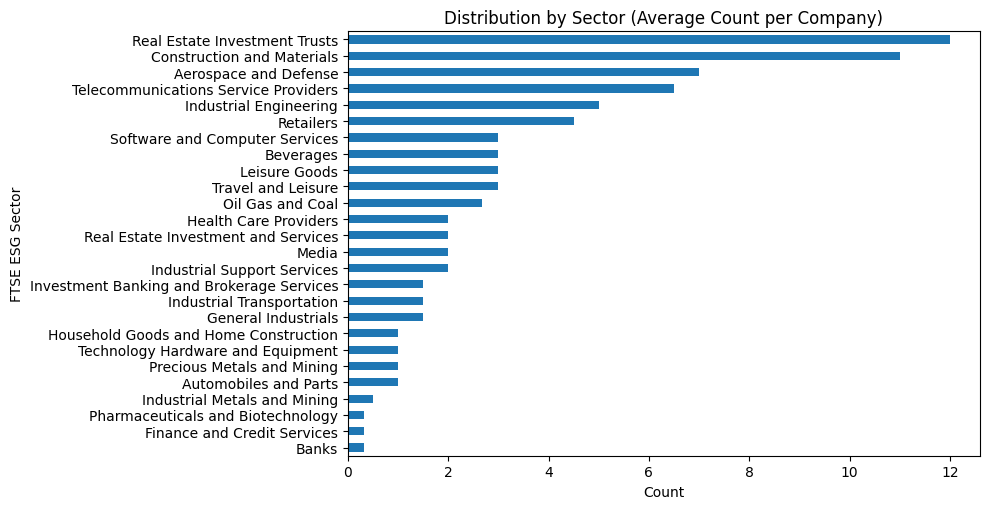


--- Distribution by Subsector (Average Count per Company) ---
                                        Count  Percent  NumCompanies
FTSE ESG Subsector                                                  
Diversified REITs                       12.00    10.91             1
Construction                            11.00    10.00             1
Defense                                  7.00     6.36             1
Telecommunications Services              6.50    11.82             2
Home Improvement Retailers               6.00     5.45             1
Machinery: Specialty                     5.00     4.55             1
Oil Refining and Marketing               3.00     5.45             2
Soft Drinks                              3.00     5.45             2
Computer Services                        3.00     5.45             2
Airlines                                 3.00     2.73             1
Marine Transportation                    3.00     2.73             1
Specialty Retailers                     

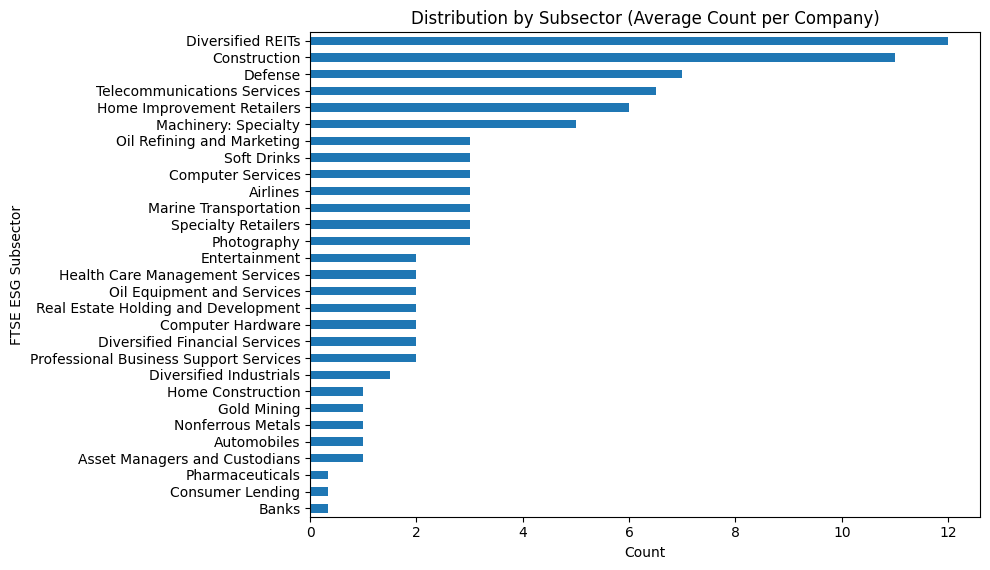


Saved strong correlations to 'strong_correlations_multi_tf.csv'


In [46]:
# @title
### Correlation Analysis ###

# Constants for correlation thresholds
STRONG_POS_THRESHOLD = 0.65
STRONG_NEG_THRESHOLD = -0.65

# ESG rating breakpoints
def esg_group(rating: float) -> str:
    """
    Bin FTSE ESG ratings into categories.
    """
    if pd.isna(rating):
        return 'Missing'
    if rating >= 4:
        return 'High'
    if rating >= 3:
        return 'Medium'
    if rating < 2.5:
        return 'Low'
    return 'Other'


def load_and_filter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only 'strong' correlations and classify by ESG groups.
    """
    mask_strong = (df['Correlation'] > STRONG_POS_THRESHOLD) | (df['Correlation'] < STRONG_NEG_THRESHOLD)
    strong = df.loc[mask_strong].copy()
    strong['ESG_Rating_Group'] = strong['FTSE ESG Rating 2025'].apply(esg_group)
    return strong


def summarize_distribution(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Return a DataFrame with counts and percentages for each unique value in column.
    """
    counts = df[column].value_counts(dropna=False)
    percents = df[column].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({
        'Count': counts,
        'Percent': percents.round(2)
    }).sort_values('Count', ascending=False)
    return summary

def plot_horizontal_bar(summary: pd.DataFrame,
                        title: str,
                        width: float = 10,
                        per_bar: float = 0.2,
                        min_h: float = 2.5,
                        max_h: float = 12):
    """
    Render a horizontal bar chart with dynamic height

    """
    # number of categories plotted
    n = summary.shape[0]

    # dynamic height, then clamp
    height = min(max(n * per_bar, min_h), max_h)

    ax = summary['Count'].plot.barh(figsize=(width, height))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Count')
    plt.tight_layout()
    plt.show()

def main():
    # Initialize
    total = len(multi_tf_corr_df)
    print(f"Total correlations: {total}")

    # Filter & tag
    strong_df = load_and_filter(multi_tf_corr_df)
    strong_count = len(strong_df)
    pct_strong = strong_count / total * 100
    print(f"Strong correlations (>|0.65|): {strong_count} ({pct_strong:.2f}%)")

    # --- which categories get averaged over # companies ---
    average_cols = [
        'FTSE ESG Industry',
        'FTSE ESG Sector',
        'FTSE ESG Subsector',
        'Market Cap'
    ]
    # build a Series: for each category → number of unique companies in that bucket
    denoms = {
        cat: esg_df.groupby(cat)['Name'].nunique()
        for cat in average_cols
        if cat in esg_df.columns
    }

    # Columns to summarize
    cols = [
        ('Company', 'Company'),
        ('Trend_Term', 'Trend Term'),
        ('Trends_Region', 'Trends Region'),
        ('Lag_Weeks', 'Lag in Weeks'),
        ('Date_Range', 'Date Range'),
        ('ESG_Rating_Group', 'ESG Rating Group'),
        ('Keyword_Category', 'Keyword Category'),
        ('FTSE ESG Country Code', 'Country Code'),
        ('Market Cap', 'Market Capitalization'),
        ('FTSE ESG Industry', 'Industry'),
        ('FTSE ESG Sector', 'Sector'),
        ('FTSE ESG Subsector', 'Subsector'),
    ]

    for col_key, title in cols:
        summary = summarize_distribution(strong_df, col_key)

        if col_key in denoms:
            # Compute average = raw count ÷ number of companies in this category
            summary['NumCompanies'] = summary.index.map(denoms[col_key]).fillna(0).astype(int)
            summary['Count'] = (summary['Count'] / summary['NumCompanies']).round(2)
            summary = summary.sort_values('Count', ascending=False)

            print(f"\n--- Distribution by {title} (Average Count per Company) ---")
            print(summary[['Count', 'Percent', 'NumCompanies']])
            plot_horizontal_bar(
                summary,
                f"Distribution by {title} (Average Count per Company)"
            )
        else:
            # Raw‐count
            print(f"\n--- Distribution by {title} (Count) ---")
            print(summary)
            plot_horizontal_bar(
                summary,
                f"Distribution by {title} (Count)"
            )

    # Save results
    out_file = 'strong_correlations_multi_tf.csv'
    strong_df.to_csv(out_file, index=False)
    print(f"\nSaved strong correlations to '{out_file}'")


if __name__ == '__main__':
    main()


## Six-Month Windows

Since most of the strong correlations in the prliminary corrlation analysis were found in the six-month timeframe, a further correlation analysis is performed for a "rolling" window of six months each from Jan 2020 to Dec 2024, with a 13-week step such that each timeframe has a 50% overlap with the previous one.

In [14]:
# @title
# Cache trend & stock columns
trend_cols = [c for c in master_df.columns if c.startswith('Trends ')]
stock_cols = [c for c in master_df.columns if c.startswith('Stock_Returns_')]

# Create 6-month rolling windows (26 weeks) with 50% overlap (step = 13)
WINDOW_SIZE = 26
STEP_SIZE = 13

first_wk = master_df['Week_No'].min()
last_wk = master_df['Week_No'].max()

week_date_map = master_df.set_index('Week_No')['Week']
timeframes = []
week_slices = {}

current_start = first_wk
while current_start + WINDOW_SIZE - 1 <= last_wk:
    current_end = current_start + WINDOW_SIZE - 1
    label = f"Weeks {current_start}-{current_end}"
    date_range = f"{week_date_map.loc[current_start]:%Y-%m-%d} to {week_date_map.loc[current_end]:%Y-%m-%d}"
    timeframes.append({
        'label': label,
        'start_wk': current_start,
        'end_wk': current_end,
        'Date_Range': date_range
    })
    week_slices[(current_start, current_end)] = master_df[
        (master_df['Week_No'] >= current_start) &
        (master_df['Week_No'] <= current_end)
    ].copy()
    current_start += STEP_SIZE

# Create ESG lookup dictionary
esg_lookup = esg_df.set_index('Name').to_dict(orient='index')

# Run correlation analysis
LAGS = [0, 1, 2, 3, 4]
results = []
skipped_constant_series = 0
std_threshold = 1e-9  # Threshold to exclude constant/near-constant series

total_companies = len(stock_cols)
for idx, stock_col in enumerate(stock_cols, start=1):
    company = stock_col.replace('Stock_Returns_', '')
    esg_data = esg_lookup.get(company)
    if esg_data is None:
        continue

    print(f"[{idx}/{total_companies}] Processing company: {company}")

    for trend_col in trend_cols:
        for lag in LAGS:
            for tf in timeframes:
                sub = week_slices[(tf['start_wk'], tf['end_wk'])].copy()
                sub['trend_lagged'] = sub[trend_col].shift(lag)
                tmp = sub[[stock_col, 'trend_lagged']].dropna()

                if len(tmp) >= 5:
                    std_stock = tmp[stock_col].std()
                    std_trend = tmp['trend_lagged'].std()

                    if std_stock > std_threshold and std_trend > std_threshold:
                        corr = np.corrcoef(tmp[stock_col], tmp['trend_lagged'])[0, 1]
                        if not np.isnan(corr):
                            results.append({
                                'Company':     company,
                                'Trend_Term':  trend_col,
                                'Lag_Weeks':   lag,
                                'Time_Period': tf['label'],
                                'Date_Range':  tf['Date_Range'],
                                'Correlation': corr,
                                **esg_data
                            })
                    else:
                        skipped_constant_series += 1

# Convert results to DataFrame and clean up trend labels
six_month_corr_df = pd.DataFrame(results)

six_month_corr_df['Trends_Region'] = six_month_corr_df['Trend_Term'].str.extract(r'\((.*?)\)')
six_month_corr_df['Trend_Term'] = (
    six_month_corr_df['Trend_Term']
      .str.replace(r'^Trends\s+', '', regex=True)
      .str.replace(r'\s*\(.*?\)', '', regex=True)
)

# Append keyword category
six_month_corr_df = (
    six_month_corr_df
      .merge(keywords_df, left_on="Trend_Term", right_on="Keyword", how="left")
      .rename(columns={"Keyword Category": "Keyword_Category"})
      .drop(columns=["Keyword"])
)

# Save output
six_month_corr_df.to_csv('six_month_correlation.csv', index=False)
# files.download('six_month_correlation.csv') # Uncomment to trigger automatic download

# Summary
print(f"\nSkipped {skipped_constant_series:,} correlation attempts due to constant or near-constant input series.")


[1/45] Processing company: Ashok Leyland Limited
[2/45] Processing company: Barclays PLC
[3/45] Processing company: Berkshire Hathaway Inc. Class A
[4/45] Processing company: Bharat Heavy Electricals Limited
[5/45] Processing company: Bharat Petroleum Corporation Limited
[6/45] Processing company: BioMarin Pharmaceutical Inc.
[7/45] Processing company: Chemring Group PLC
[8/45] Processing company: Cincinnati Financial Corporation
[9/45] Processing company: Clarkson PLC
[10/45] Processing company: Close Brothers Group plc
[11/45] Processing company: Coca-Cola Europacific Partners plc
[12/45] Processing company: Coca-Cola HBC AG
[13/45] Processing company: EasyJet plc
[14/45] Processing company: Fresnillo PLC
[15/45] Processing company: Godrej Industries Limited
[16/45] Processing company: Grainger plc
[17/45] Processing company: HP Inc.
[18/45] Processing company: Halliburton Company
[19/45] Processing company: Hewlett Packard Enterprise Co.
[20/45] Processing company: Hindustan Zinc Li

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Skipped 468,180 correlation attempts due to constant or near-constant input series.


Total correlations: 2691045
Strong correlations (>|0.65|): 3244 (0.12%)

--- Distribution by Company (Count) ---
                                             Count  Percent
Company                                                    
Coca-Cola HBC AG                               166     5.12
Hindustan Zinc Limited                         129     3.98
Serco Group plc                                122     3.76
NVR, Inc.                                      111     3.42
UnitedHealth Group Incorporated                106     3.27
O'Reilly Automotive, Inc.                      100     3.08
Tech Mahindra Limited                           99     3.05
Chemring Group PLC                              97     2.99
Power Finance Corporation Limited               96     2.96
Kier Group plc                                  93     2.87
Vodafone Idea Ltd                               91     2.81
Close Brothers Group plc                        90     2.77
Grainger plc                                   

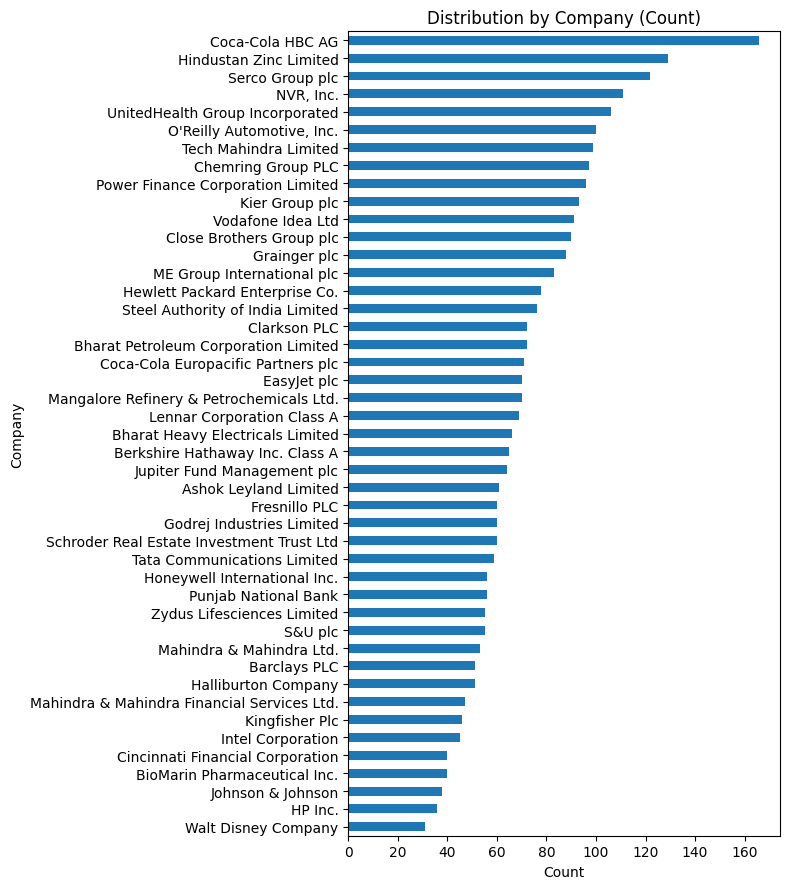


--- Distribution by Trend Term (Count) ---
                                     Count  Percent
Trend_Term                                         
Conflict                                79     2.44
War                                     77     2.37
Berkshire Hathaway                      71     2.19
Recession                               59     1.82
Pandemic                                57     1.76
...                                    ...      ...
ME Group International                   8     0.25
Growth                                   8     0.25
NVR inc                                  7     0.22
Election                                 5     0.15
Mangalore Refinery & Petrochemicals      4     0.12

[124 rows x 2 columns]


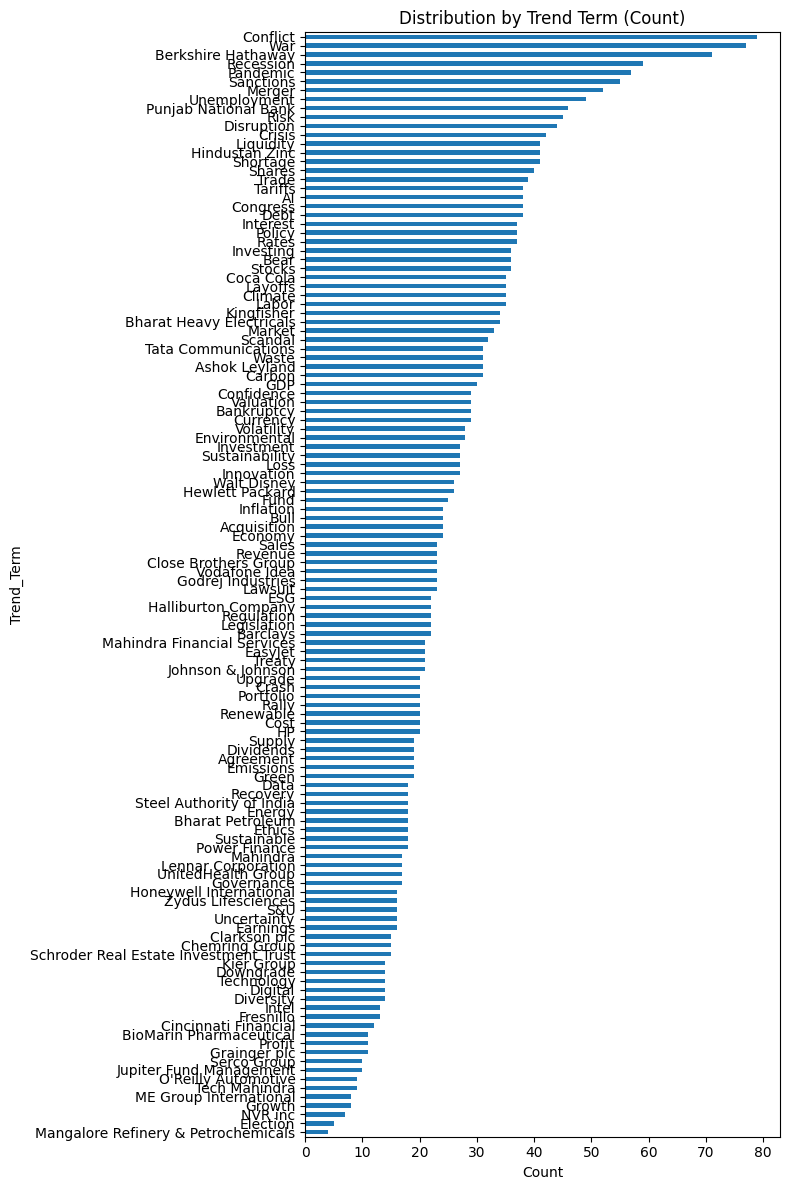


--- Distribution by Trends Region (Count) ---
                Count  Percent
Trends_Region                 
Worldwide         634    19.54
United Kingdom    580    17.88
United States     560    17.26
India             529    16.31
Australia         475    14.64
Singapore         466    14.36


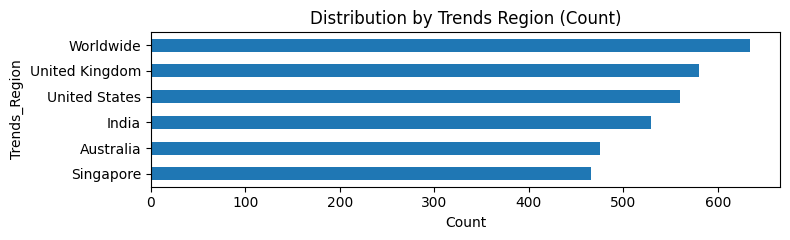


--- Distribution by Lag in Weeks (Count) ---
           Count  Percent
Lag_Weeks                
4            907    27.96
3            617    19.02
1            593    18.28
2            575    17.73
0            552    17.02


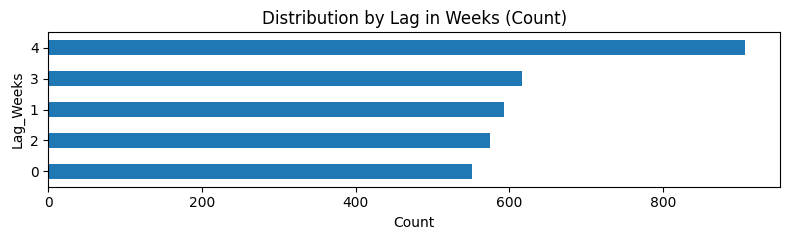


--- Distribution by Date Range (Count) ---
                          Count  Percent
Date_Range                              
2020-04-05 to 2020-09-27    257     7.92
2020-01-05 to 2020-06-28    246     7.58
2021-10-03 to 2022-03-27    215     6.63
2023-12-31 to 2024-06-23    213     6.57
2021-01-03 to 2021-06-27    207     6.38
2022-04-03 to 2022-09-25    185     5.70
2023-01-01 to 2023-06-25    184     5.67
2020-10-04 to 2021-03-28    178     5.49
2023-04-02 to 2023-09-24    174     5.36
2020-07-05 to 2020-12-27    169     5.21
2022-01-02 to 2022-06-26    168     5.18
2021-04-04 to 2021-09-26    160     4.93
2024-03-31 to 2024-09-22    159     4.90
2023-10-01 to 2024-03-24    141     4.35
2022-10-02 to 2023-03-26    138     4.25
2023-07-02 to 2023-12-24    118     3.64
2021-07-04 to 2021-12-26    116     3.58
2024-06-30 to 2024-12-22    116     3.58
2022-07-03 to 2022-12-25    100     3.08


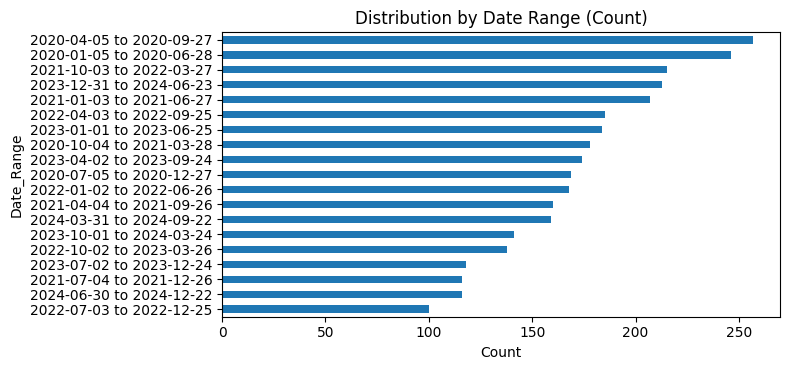


--- Distribution by ESG Rating Group (Count) ---
                  Count  Percent
ESG_Rating_Group                
High               1104    34.03
Low                1096    33.79
Medium             1044    32.18


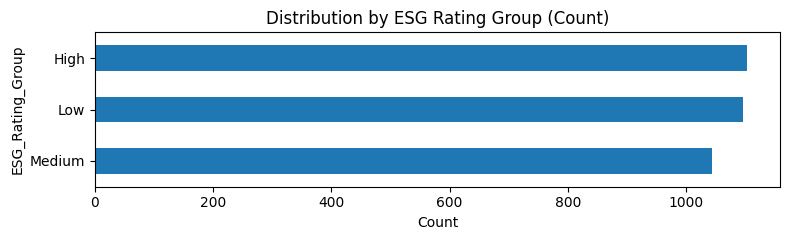


--- Distribution by Keyword Category (Count) ---
                  Count  Percent
Keyword_Category                
Company Name        900    27.74
Stock               561    17.29
Industry            475    14.64
Economic            387    11.93
ESG                 334    10.30
Political           320     9.86
Global              267     8.23


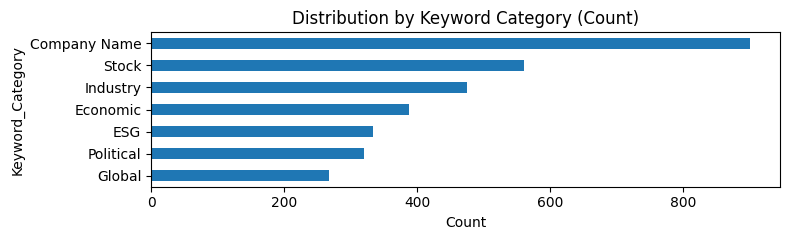


--- Distribution by Country Code (Count) ---
                       Count  Percent
FTSE ESG Country Code                
UK                      1217    37.52
IND                     1090    33.60
USA                      937    28.88


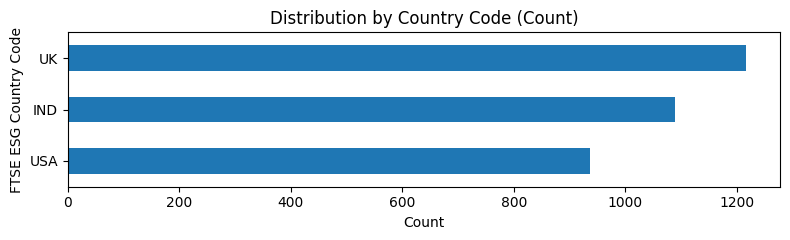


--- Distribution by Market Capitalization (Average Count per Company) ---
            Count  Percent  NumCompanies
Market Cap                              
Small Cap   79.71    17.20             7
Large Cap   71.91    50.99            23
Mid Cap     68.80    31.81            15


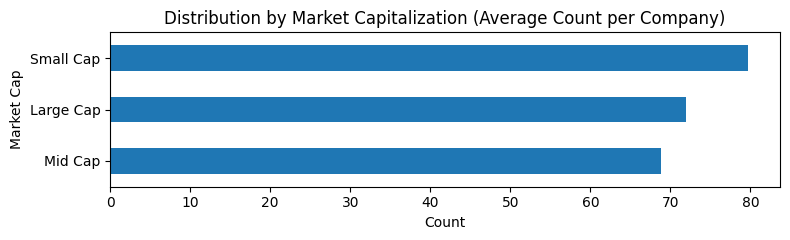


--- Distribution by Industry (Average Count per Company) ---
                         Count  Percent  NumCompanies
FTSE ESG Industry                                    
Consumer Staples        118.50     7.31             2
Basic Materials          88.33     8.17             3
Industrials              78.38    19.33             8
Telecommunications       75.00     4.62             2
Real Estate              74.00     4.56             2
Consumer Discretionary   70.38    17.36             8
Technology               64.50     7.95             4
Energy                   64.33     5.95             3
Financials               62.67    17.39             9
Health Care              59.75     7.37             4


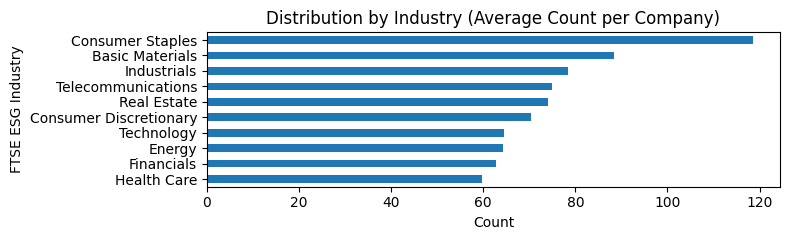


--- Distribution by Sector (Average Count per Company) ---
                                            Count  Percent  NumCompanies
FTSE ESG Sector                                                         
Industrial Support Services                122.00     3.76             1
Beverages                                  118.50     7.31             2
Health Care Providers                      106.00     3.27             1
Industrial Metals and Mining               102.50     6.32             2
Aerospace and Defense                       97.00     2.99             1
Construction and Materials                  93.00     2.87             1
Household Goods and Home Construction       90.00     5.55             2
Software and Computer Services              88.50     5.46             2
Real Estate Investment and Services         88.00     2.71             1
Leisure Goods                               83.00     2.56             1
Telecommunications Service Providers        75.00     4.62      

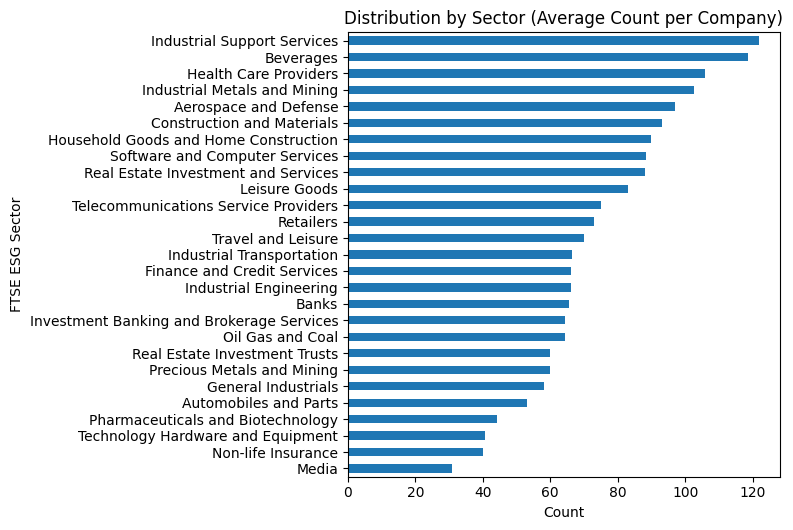


--- Distribution by Subsector (Average Count per Company) ---
                                         Count  Percent  NumCompanies
FTSE ESG Subsector                                                   
Nonferrous Metals                       129.00     3.98             1
Professional Business Support Services  122.00     3.76             1
Soft Drinks                             118.50     7.31             2
Health Care Management Services         106.00     3.27             1
Specialty Retailers                     100.00     3.08             1
Defense                                  97.00     2.99             1
Construction                             93.00     2.87             1
Home Construction                        90.00     5.55             2
Computer Services                        88.50     5.46             2
Real Estate Holding and Development      88.00     2.71             1
Photography                              83.00     2.56             1
Iron and Steel             

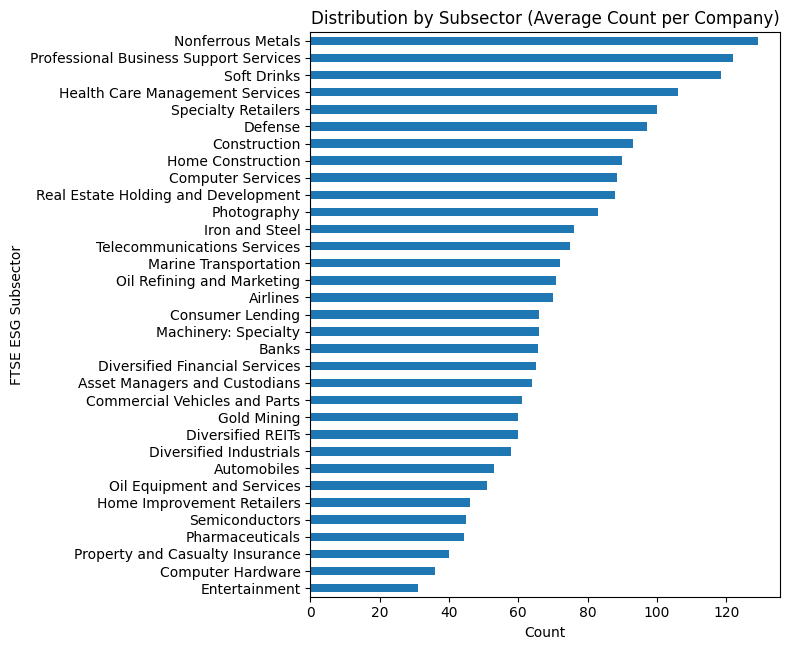


Saved strong correlations to 'strong_correlations_six_month.csv'


In [47]:
# @title
### Correlation Analysis ###

# Constants for correlation thresholds
STRONG_POS_THRESHOLD = 0.65
STRONG_NEG_THRESHOLD = -0.65

# ESG rating breakpoints
def esg_group(rating: float) -> str:
    """
    Bin FTSE ESG ratings into categories.
    """
    if pd.isna(rating):
        return 'Missing'
    if rating >= 4:
        return 'High'
    if rating >= 3:
        return 'Medium'
    if rating < 2.5:
        return 'Low'
    return 'Other'


def load_and_filter(df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only 'strong' correlations and classify by ESG groups.
    """
    mask_strong = (df['Correlation'] > STRONG_POS_THRESHOLD) | (df['Correlation'] < STRONG_NEG_THRESHOLD)
    strong = df.loc[mask_strong].copy()
    strong['ESG_Rating_Group'] = strong['FTSE ESG Rating 2025'].apply(esg_group)
    return strong


def summarize_distribution(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """
    Return a DataFrame with counts and percentages for each unique value in column.
    """
    counts = df[column].value_counts(dropna=False)
    percents = df[column].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({
        'Count': counts,
        'Percent': percents.round(2)
    }).sort_values('Count', ascending=False)
    return summary


def plot_horizontal_bar(summary: pd.DataFrame,
                        title: str,
                        width: float = 8,
                        per_bar: float = 0.2,
                        min_h: float = 2.5,
                        max_h: float = 12):
    """
    Render a horizontal bar chart with dynamic height

    """
    # number of categories plotted
    n = summary.shape[0]

    # dynamic height, then clamp
    height = min(max(n * per_bar, min_h), max_h)

    ax = summary['Count'].plot.barh(figsize=(width, height))
    ax.invert_yaxis()
    ax.set_title(title)
    ax.set_xlabel('Count')
    plt.tight_layout()
    plt.show()


def main():
    # Initialize
    total = len(six_month_corr_df)
    print(f"Total correlations: {total}")

    # Filter & tag
    strong_df = load_and_filter(six_month_corr_df)
    strong_count = len(strong_df)
    pct_strong = strong_count / total * 100
    print(f"Strong correlations (>|0.65|): {strong_count} ({pct_strong:.2f}%)")


    # --- which categories get averaged over # companies ---
    average_cols = [
        'FTSE ESG Industry',
        'FTSE ESG Sector',
        'FTSE ESG Subsector',
        'Market Cap'
    ]
    # build a Series: for each category → number of unique companies in that bucket
    denoms = {
        cat: esg_df.groupby(cat)['Name'].nunique()
        for cat in average_cols
        if cat in esg_df.columns
    }

    # Columns to summarize
    cols = [
        ('Company', 'Company'),
        ('Trend_Term', 'Trend Term'),
        ('Trends_Region', 'Trends Region'),
        ('Lag_Weeks', 'Lag in Weeks'),
        ('Date_Range', 'Date Range'),
        ('ESG_Rating_Group', 'ESG Rating Group'),
        ('Keyword_Category', 'Keyword Category'),
        ('FTSE ESG Country Code', 'Country Code'),
        ('Market Cap', 'Market Capitalization'),
        ('FTSE ESG Industry', 'Industry'),
        ('FTSE ESG Sector', 'Sector'),
        ('FTSE ESG Subsector', 'Subsector'),
    ]

    for col_key, title in cols:
        summary = summarize_distribution(strong_df, col_key)

        if col_key in denoms:
            # Compute average = raw count ÷ number of companies in this category
            summary['NumCompanies'] = summary.index.map(denoms[col_key]).fillna(0).astype(int)
            summary['Count'] = (summary['Count'] / summary['NumCompanies']).round(2)
            summary = summary.sort_values('Count', ascending=False)

            print(f"\n--- Distribution by {title} (Average Count per Company) ---")
            print(summary[['Count', 'Percent', 'NumCompanies']])
            plot_horizontal_bar(
                summary,
                f"Distribution by {title} (Average Count per Company)"
            )
        else:
            # Raw‐count
            print(f"\n--- Distribution by {title} (Count) ---")
            print(summary)
            plot_horizontal_bar(
                summary,
                f"Distribution by {title} (Count)"
            )

    # Save results
    out_file = 'strong_correlations_six_month.csv'
    strong_df.to_csv(out_file, index=False)
    # files.download(out_file) # Uncomment to trigger auto-download
    print(f"\nSaved strong correlations to '{out_file}'")


if __name__ == '__main__':
    main()


# Dynamic AutoRegression (AR-X)

Correlation analysis revealed certain patterns but the true test - with both directionality (Trend --> stock return) and a guard against multiple-testing errors (coincidental/spurious relationships) - lies in fitting dynamic autoregressive models with exogenous Google-Trends inputs (AR-X).

Primary analysis is performed with univariate AR-X with a single Trends predictor.

Lag order is selected using AIC (Akaike Information Criterion).

Granger directionality is tested with the Wald F-test and Benjamini–Hochberg FDR control against multiple-testing errors.

Secondary analysis is performed with univariate AR-X with multiple Trends predictors. Quality of models is tested through out-of-sample Root Mean Squared Error (RMSE), i.e. test set, and its economic viability judged by taking the ratio of RMSE to stock volatility.

Six timeframes will be used for this method: 4 years (2021–2024), 3 years (2022–2024) and four 1-year windows covering the same period.
This is due to the following:
1. a short span such as a 6-month timeframe models noise, per the rule of thumb for minimum observations in VAR modeling, which recommends that the number of observations should be vastly greater than the number of estimated parameters (typically, T > k × p × 10).
2. a 2-year window will not include any new information for VAR modeling, unlike with correlation analysis.
3. a 4-year window will serve as a check for whether most of the relationships we observe in the periods beyond 2022 are influenced by specific events (such as the Russo-Ukrainian War).
4. the full 5-year timeframe covers the covid-19 turmoil, and it does not add predictive value for the post-disruptive period of today.

### Checking Stationarity

In [16]:
# @title
### Checking Stationarity ###

import warnings
warnings.filterwarnings("ignore", message="divide by zero encountered in log")

# Run ADF test on all numeric columns in master_df and print summary
stationary_cols = []
non_stationary_cols = []
checked_cols = 0

for col in master_df.select_dtypes(include='number').columns:
    series = master_df[col].dropna()
    if len(series) < 10:
        continue
    try:
        p_value = adfuller(series)[1]
        if p_value < 0.05:
            stationary_cols.append(col)
        else:
            non_stationary_cols.append(col)
        checked_cols += 1
    except:
        continue  # skip columns where ADF fails

print(f"Total columns checked: {checked_cols}")
print(f"Stationary columns: {len(stationary_cols)}")
print(f"Non-stationary columns: {len(non_stationary_cols)}")

# Process non-stationary columns if any exist
if non_stationary_cols:
    print("\nNon-stationary column name(s):")
    for col in non_stationary_cols:
        print(f" - {col}")

    # Difference all non-stationary columns
    for col in non_stationary_cols:
        master_df[col] = master_df[col].diff().fillna(0)

    print("Non-stationary column(s) differenced.")


Total columns checked: 749
Stationary columns: 748
Non-stationary columns: 1

Non-stationary column name(s):
 - Trends Inflation (Australia)
Non-stationary column(s) differenced.


## **Primary Analysis**

Primary analysis will be carried out on the same dataset as correlation analysis, with every company modeled against each of the 625 Trends timeseries to form univariate AR-X models. Output will include the p-value, q-value and F-statistic for each AR-X model.

### Modeling

In [17]:
# @title

# SANITY CHECKS

assert 'master_df' in globals(),  "master_df DataFrame not found."
if 'Week' not in master_df.columns:
    raise ValueError("master_df must contain a 'Week' date column.")
if not any(c.startswith('Trends ') for c in master_df.columns):
    raise ValueError("No columns starting with 'Trends ' found.")
if not any(c.startswith('Stock_Returns_') for c in master_df.columns):
    raise ValueError("No columns starting with 'Stock_Returns_' found.")

master_df = master_df.copy()
master_df['Week'] = pd.to_datetime(master_df['Week'])
master_df.sort_values('Week', inplace=True, ignore_index=True)

trend_cols  = [c for c in master_df.columns if c.startswith('Trends ')]
stock_cols  = [c for c in master_df.columns if c.startswith('Stock_Returns_')]

# ESG lookup
esg_lookup = {}
if 'esg_df' in globals() and not esg_df.empty:
    esg_lookup = esg_df.set_index('Name').to_dict(orient='index')


# DEFINE WINDOWS

WINDOWS = {
    '4y'       : 208,
    '3y'       : 156,
    '1y_2021'  :  52,
    '1y_2022'  :  52,
    '1y_2023'  :  52,
    '1y_2024'  :  52,
}


# PRE-SLICE EACH WINDOW

slices = {}
for label, span in WINDOWS.items():
    if label.startswith('1y_'):
        yr  = int(label[-4:])
        sub = master_df[master_df['Week'].dt.year == yr].copy()
    else:
        sub = master_df.iloc[-span:].copy()
    if len(sub) < span // 2:
        print(f'Window {label} skipped – too few observations.')
    else:
        slices[label] = sub.reset_index(drop=True)


# WORKER FUNCTION (one fit, one test per pair)

CONST_THRESH = 1e-9

date_ranges = {
    lbl: f"{df_w['Week'].iloc[0]:%Y-%m-%d} to {df_w['Week'].iloc[-1]:%Y-%m-%d}"
    for lbl, df_w in slices.items()
}

def run_pair(df, stock_col, trend_col, maxlag, window_label):
    y = df[[stock_col, trend_col]].dropna()
    if (len(y) < maxlag*2 + 10 or
        y[stock_col].var() < CONST_THRESH or
        y[trend_col].var() < CONST_THRESH):
        return None

    try:
        order = sm.tsa.VAR(y).select_order(maxlags=maxlag).aic
    except (LinAlgError, ValueError):
        return None
    if not order or np.isnan(order):
        return None

    try:
        res = sm.tsa.VAR(y).fit(order,
                                trend='c')
    except (LinAlgError, ValueError):
        return None

    try:
        gc = res.test_causality(causing=trend_col,
                                caused=stock_col,
                                kind='f')
    except (LinAlgError, ValueError):
        return None

    gc   = res.test_causality(causing=trend_col, caused=stock_col, kind='f')

    company = stock_col.replace('Stock_Returns_', '')
    trend   = trend_col.replace('Trends ', '')

    m                = re.search(r'\((.*?)\)', trend_col)
    trend_region    = m.group(1) if m else None
    trend_base_clean = re.sub(r'\s*\(.*?\)', '', trend_col).replace('Trends ', '')

    rec = {
        'Window'         : window_label,
        'Date_Range'     : date_ranges[window_label],
        'Company'        : stock_col.replace('Stock_Returns_', ''),
        'Trend_Term'     : trend_base_clean,
        'Trends_Region' : trend_region,
        'Lag_Weeks'      : int(order),
        'F_stat'         : float(gc.test_statistic),
        'p_value'        : float(gc.pvalue),
    }
    rec.update(esg_lookup.get(rec['Company'], {}))
    return rec


# MAIN PARALLEL LOOP

records = []
for wlabel, df_w in slices.items():
    nobs   = len(df_w)
    maxlag = 8 if nobs > 100 else 4
    print(f'Window {wlabel}: {nobs} obs, maxlag={maxlag}')

    total_companies = len(stock_cols)
    for idx, stock in enumerate(stock_cols, 1):
        # Progress monitoring
        print(f"[{idx}/{total_companies}] {stock.replace('Stock_Returns_','')}", flush=True)

        tasks = (delayed(run_pair)(df_w, stock, trend, maxlag, wlabel)
                 for trend in trend_cols)

        out = Parallel(n_jobs=-1, batch_size=256, verbose=0)(tasks)
        records.extend([r for r in out if r])


# FDR CORRECTION

results = pd.DataFrame(records)
if not results.empty:
    results['q_value'] = multipletests(results['p_value'],
                                       method='fdr_bh')[1]

    # Append keyword categories
    if 'keywords_df' in globals():
        results = (
            results
              .merge(keywords_df, left_on="Trend_Term", right_on="Keyword", how="left")
              .rename(columns={"Keyword Category": "Keyword_Category"})
              .drop(columns=["Keyword"])
        )

    # SAVE

    fname = f'granger_results_{dt.datetime.now():%Y%m%d_%H%M}.csv'
    results.to_csv(fname, index=False)
    # files.download(fname) # Uncomment to trigger automatic download
    granger_df = results.copy()
    print(f'\nFinished. Results saved to “{fname}”  '
          f'({results.shape[0]} rows).')
else:
    print("No valid AR-X/Granger results were produced.")


Window 4y: 208 obs, maxlag=8
[1/45] Ashok Leyland Limited
[2/45] Barclays PLC
[3/45] Berkshire Hathaway Inc. Class A
[4/45] Bharat Heavy Electricals Limited
[5/45] Bharat Petroleum Corporation Limited
[6/45] BioMarin Pharmaceutical Inc.
[7/45] Chemring Group PLC
[8/45] Cincinnati Financial Corporation
[9/45] Clarkson PLC
[10/45] Close Brothers Group plc
[11/45] Coca-Cola Europacific Partners plc
[12/45] Coca-Cola HBC AG
[13/45] EasyJet plc
[14/45] Fresnillo PLC
[15/45] Godrej Industries Limited
[16/45] Grainger plc
[17/45] HP Inc.
[18/45] Halliburton Company
[19/45] Hewlett Packard Enterprise Co.
[20/45] Hindustan Zinc Limited
[21/45] Honeywell International Inc.
[22/45] Intel Corporation
[23/45] Johnson & Johnson
[24/45] Jupiter Fund Management plc
[25/45] Kier Group plc
[26/45] Kingfisher Plc
[27/45] Lennar Corporation Class A
[28/45] ME Group International plc
[29/45] Mahindra & Mahindra Financial Services Ltd.
[30/45] Mahindra & Mahindra Ltd.
[31/45] Mangalore Refinery & Petrochemi

### Analyzing Distributions & Relationships (Tooltips in charts list top ten companies/trendterms by value - largest to smallest - within that filter)

In [64]:
# @title
# Constants
ALPHA = 0.05
FSTAT_CUTOFF = 5

# ESG rating break-points
def esg_group(rating: float) -> str:
    if rating >= 4:
        return 'High'
    if rating >= 3:
        return 'Medium'
    if rating < 2.5:
        return 'Low'
    return 'Other'

# Load and filter strong Granger-causal links
def load_and_filter(df: pd.DataFrame) -> pd.DataFrame:
    # Determine significance column
    if 'q_value' in df.columns:
        mask = (df['q_value'] < ALPHA) & (df['F_stat'] > FSTAT_CUTOFF)
    else:
        mask = (df['p_value'] < ALPHA) & (df['F_stat'] > FSTAT_CUTOFF)

    strong = df[mask].copy()
    strong['ESG_Rating_Group'] = strong['FTSE ESG Rating 2025'].apply(esg_group)
    return strong

# Main analysis
def main(granger_df: pd.DataFrame, esg_df: pd.DataFrame):
    import pandas as pd
    import plotly.express as px
    from matplotlib import colormaps as cm
    from IPython.display import display, Markdown
    import re
    import plotly.graph_objects as go

    df = granger_df.copy()
    total_tests = len(df)
    print(f"Total Granger tests: {total_tests}")
    strong_df = load_and_filter(df)
    strong_cnt = len(strong_df)
    pct_strong = strong_cnt / total_tests * 100
    print(f"Significant results (p/q < {ALPHA} and F-stat > {FSTAT_CUTOFF}): {strong_cnt} ({pct_strong:.2f}%)")

    # Function to normalize names (remove punctuation/suffixes)
    def normalize_name(name: str) -> str:
        if pd.isna(name): return ''
        # Lowercase, remove punctuation
        s = re.sub(r"[^a-zA-Z0-9 ]", '', name.lower())
        # Remove common suffixes
        for suffix in [' limited', ' ltd', ' inc', ' plc', '&', 'and']:
            s = s.replace(suffix, '')
        return s.strip()

    # Classify trend-match type
    def classify_match(row):
        term = row['Trend_Term']
        cat = row['Keyword_Category']
        comp = row['Company']
        if cat != 'Company Name':
            return 'Non-Company'
        nterm = normalize_name(term)
        ncomp = normalize_name(comp)
        if len(nterm) < 4:
            return 'Non-Company'
        # Self-company if normalized term is in normalized company name (word boundary)
        if re.search(rf"\b{re.escape(nterm)}\b", ncomp):
            return 'Self-Company'
        else:
            return 'Other-Company'

    strong_df['Match_Type'] = strong_df.apply(classify_match, axis=1)


    # Precompute denominators
    denoms = {}
    for cat in ['FTSE ESG Industry', 'FTSE ESG Sector', 'FTSE ESG Subsector', 'Market Cap']:
        if cat in esg_df.columns:
            denoms[cat] = esg_df.groupby(cat)['Name'].nunique()

    # Top 10 hover function
    def top_10_with_ellipsis(series):
        counts = pd.Series(series).value_counts()
        top = counts.head(10).index.tolist()
        result = '<br>'.join(top)
        if len(counts) > 10:
            result += '<br>...'
        return result

    # Bar chart summary
    def build_summary(col: str, normalize: bool=False) -> pd.DataFrame:
        grp = strong_df.groupby(col).agg(
            Count=('Company', 'size'),
            Companies=('Company', top_10_with_ellipsis),
            Trends=('Trend_Term', top_10_with_ellipsis)
        ).reset_index()
        if normalize and col in denoms:
            grp['NumCompanies'] = grp[col].map(denoms[col]).fillna(0).astype(int)
            grp['LinksPerCompany'] = (grp['Count'] / grp['NumCompanies']).round(0).fillna(0).astype(int)
        return grp

    # Matrix building
    def build_matrix(x_col: str, y_col: str, normalize: bool=False) -> pd.DataFrame:
        matrix = strong_df.groupby([y_col, x_col]).agg(
            Count=('Company', 'size'),
            Companies=('Company', top_10_with_ellipsis),
            Trends=('Trend_Term', top_10_with_ellipsis)
        ).reset_index()
        if normalize and y_col in denoms:
            matrix = matrix.merge(denoms[y_col].rename('NumCompanies'), on=y_col, how='left')
            matrix['LinksPerCompany'] = (matrix['Count'] / matrix['NumCompanies']).round(0).astype('Int64')
        return matrix

    # Matrix plotting
    def plot_heatmap(matrix_df: pd.DataFrame, x_col: str, y_col: str, normalize: bool=False):
        z_col = 'LinksPerCompany' if normalize and 'LinksPerCompany' in matrix_df.columns else 'Count'
        x_label = display_names.get(x_col, x_col)
        y_label = display_names.get(y_col, y_col)

        n_y = matrix_df[y_col].nunique()
        if n_y <= 10:
            bar_height = 80
            chart_height = n_y * bar_height
            chart_height = max(chart_height, 300)
        else:
            bar_height = 30
            chart_height = n_y * bar_height

        # Prepare rich hovertext
        matrix_df['HoverText'] = (
            '<b>' + matrix_df[x_col].astype(str) + ' vs ' + matrix_df[y_col].astype(str) + '</b><br>' +
            f'{z_col}: ' + matrix_df[z_col].astype(str) + '<br>' +
            'Companies:<br>' + matrix_df['Companies'] + '<br>' +
            'Trends:<br>' + matrix_df['Trends']
        )


        fig = go.Figure(
            go.Heatmap(
                x=matrix_df[x_col],
                y=matrix_df[y_col],
                z=matrix_df[z_col],
                text=matrix_df[z_col],
                texttemplate="%{text}",
                colorscale = [
                    [0.0, 'rgba(99, 110, 250, 0.05)'],
                    [0.5, 'rgba(99, 110, 250, 0.4)'],
                    [1.0, 'rgba(99, 110, 250, 1.0)']
                ]
                ,
                colorbar_title=z_col,
                hovertext=matrix_df['HoverText'],
                hoverinfo="text",
                hoverlabel=dict(bgcolor="white")
            )
        )

        fig.update_layout(
            title=f"Primary Analysis  |  {x_label} vs {y_label} ({'Average Number of Strong Causation Links per Company' if normalize else 'Count'})",
            height=chart_height,
            width=1000,
            autosize=False,
            xaxis_title=x_label,
            yaxis_title=None,
            xaxis=dict(
                showgrid=False,
                categoryorder="array",
                categoryarray=sorted(matrix_df[x_col].unique().tolist())
            ),
            yaxis=dict(
                showgrid=False,
                categoryorder="array",
                categoryarray=sorted(matrix_df[y_col].unique().tolist(), reverse=True)
            )
        )

        fig.show()


    plots = [
        ('Company', False),
        ('Trend_Term', False),
        ('Trends_Region', False),
        ('Date_Range', False),
        ('Lag_Weeks', False),
        ('ESG_Rating_Group', False),
        ('Keyword_Category', False),
        ('FTSE ESG Country Code', False),
        ('FTSE ESG Industry', True),
        ('FTSE ESG Sector', True),
        ('FTSE ESG Subsector', True),
        ('Market Cap', True)
    ]

    matrix_plots = [
        ('Trends_Region', 'Company', False),
        ('ESG_Rating_Group', 'FTSE ESG Industry', True),
        ('ESG_Rating_Group', 'FTSE ESG Sector', True),
        ('ESG_Rating_Group', 'FTSE ESG Subsector', True),
        ('ESG_Rating_Group', 'Keyword_Category', False),
        ('FTSE ESG Country Code', 'Trends_Region', False),
        ('ESG_Rating_Group', 'Market Cap', True)
    ]

    display_names = {
        'Company': 'Company',
        'Trend_Term': 'Trend Term',
        'Trends_Region': 'Trend Search Region',
        'Date_Range': 'Date Range',
        'Lag_Weeks': 'Lag Weeks',
        'ESG_Rating_Group': 'ESG Rating',
        'Keyword_Category': 'Keyword Category',
        'FTSE ESG Country Code': 'Company Country',
        'FTSE ESG Industry': 'Industry',
        'FTSE ESG Sector': 'Sector',
        'FTSE ESG Subsector': 'Sub-Sector',
        'Market Cap': 'Market Cap'
    }

    # --- Bar Charts ---
    display(Markdown("## **Distribution Analysis**"))
    display(Markdown("_(Top 10 Companies or Trends shown by largest counts in tooltips)_"))

    for col, norm in plots:
        if col not in strong_df.columns:
            continue
        summary = build_summary(col, normalize=norm)
        x = 'LinksPerCompany' if norm else 'Count'
        hover = ['Count', 'Companies', 'Trends']
        if norm:
            hover += ['NumCompanies', 'LinksPerCompany']

        if col == 'Lag_Weeks':
            summary[col] = summary[col].astype(str)

        n_bars = summary.shape[0]
        bar_height = 20
        if n_bars <= 3:
            min_height = 300
        else:
            min_height = 500
        chart_height = max(min_height, n_bars * bar_height)
        chart_width = 1000

        pretty_col = display_names.get(col, col)

        fig = px.bar(
            summary,
            x=x,
            y=col,
            orientation='h',
            title=f"Primary Analysis  |  {pretty_col} Distribution {'(Average Number of Strong Causation Links per Company)' if norm else '(Number of Strong Causation Links)'}",
            hover_data=hover,
            labels={x: 'Averaged Number of Strong Causation Links per Company' if norm else 'Count', col: col}
        )

        fig.update_layout(
            yaxis={'categoryorder': 'total ascending'},
            height=chart_height,
            width=chart_width,
            autosize=False,
            yaxis_title=None
        )

        fig.update_traces(marker_line_width=1)
        fig.show()

    # --- Matrix Heatmaps ---
    display(Markdown("## **Relationship Analysis**"))
    display(Markdown("_(Top 10 Companies or Trends shown by largest counts in tooltips)_"))

    for x_col, y_col, normalize in matrix_plots:
        if x_col not in strong_df.columns or y_col not in strong_df.columns:
            continue
        matrix = build_matrix(x_col, y_col, normalize=normalize)
        plot_heatmap(matrix, x_col, y_col, normalize=normalize)


    # --- Company Country: Side-by-Side Bar by ESG Rating ---

    # Prepare summary
    country_summary = strong_df.groupby(['FTSE ESG Country Code', 'ESG_Rating_Group']).size().reset_index(name='Count')

    # Enforce ESG order: High → Medium → Low → Missing
    esg_order = ['High', 'Medium', 'Low', 'Missing']
    country_summary['ESG_Rating_Group'] = pd.Categorical(country_summary['ESG_Rating_Group'], categories=esg_order, ordered=True)
    country_summary = country_summary.sort_values(by=['FTSE ESG Country Code', 'ESG_Rating_Group'])

    # Total counts for sorting
    total_counts = country_summary.groupby('FTSE ESG Country Code')['Count'].sum().sort_values(ascending=False)
    country_summary['FTSE ESG Country Code'] = pd.Categorical(
        country_summary['FTSE ESG Country Code'], categories=total_counts.index, ordered=True
    )

    # Plot with reversed color tones
    fig = px.bar(
        country_summary,
        x='Count',
        y='FTSE ESG Country Code',
        color='ESG_Rating_Group',
        orientation='h',
        title="Primary Analysis  |  Company Country Distribution by ESG Rating Group (Count)",
        text='Count',
        labels={
            'Count': 'Count',
            'FTSE ESG Country Code': 'Company Country',
            'ESG_Rating_Group': 'ESG Rating Group'
        },
        color_discrete_sequence=[
            'rgba(99, 110, 250, 1.0)',  # High (strongest blue)
            'rgba(99, 110, 250, 0.8)',  # Medium
            'rgba(99, 110, 250, 0.5)',  # Low
            'rgba(99, 110, 250, 0.3)'   # Missing (lightest blue)
        ]
    )

    fig.update_layout(
        barmode='group',
        height=600,
        width=1000,
        autosize=False,
        yaxis_title='Company Country',
        xaxis_title='Count',
        legend_title='ESG Rating Group',
        legend_traceorder="reversed"
    )

    fig.update_traces(marker_line_width=1)
    fig.show()


    # --- Match Type Visuals ---
    display(Markdown("## **Match Type Analysis**"))
    display(Markdown("_(Self-Company, Other-Company, Non-Company trends by ESG Rating and Company)_"))

    # --- Match_Type: Side-by-Side Bar by ESG Rating ---

    # Prepare summary
    match_summary = strong_df.groupby(['Match_Type', 'ESG_Rating_Group']).size().reset_index(name='Count')

    # Enforce ESG order: High → Medium → Low → Missing
    esg_order = ['High', 'Medium', 'Low', 'Missing']
    match_summary['ESG_Rating_Group'] = pd.Categorical(match_summary['ESG_Rating_Group'], categories=esg_order, ordered=True)
    match_summary = match_summary.sort_values(by=['Match_Type', 'ESG_Rating_Group'])

    # Plot with reversed color tones
    fig = px.bar(
        match_summary,
        x='Count',
        y='Match_Type',
        color='ESG_Rating_Group',
        orientation='h',
        title="Primary Analysis  |  Match Type Distribution by ESG Rating Group (Count)",
        text='Count',
        labels={'Count': 'Count', 'Match_Type': 'Match Type', 'ESG_Rating_Group': 'ESG Rating Group'},
        color_discrete_sequence=[
            'rgba(99, 110, 250, 1.0)',  # High (strongest blue)
            'rgba(99, 110, 250, 0.8)',  # Medium
            'rgba(99, 110, 250, 0.5)',  # Low
            'rgba(99, 110, 250, 0.3)'   # Missing (lightest blue)
        ]
    )

    fig.update_layout(
        barmode='group',
        height=500,
        width=1000,
        autosize=False,
        yaxis_title='Match Type',
        xaxis_title='Count',
        legend_title='ESG Rating Group',
        legend_traceorder="reversed"
    )

    fig.update_traces(marker_line_width=1)
    fig.show()

    # --- Match_Type: Matrix Heatmap by Company ---
    matrix = strong_df.groupby(['Company', 'Match_Type']).size().reset_index(name='Count')

    # Prepare hover text
    matrix['HoverText'] = (
        '<b>' + matrix['Match_Type'].astype(str) + ' vs ' + matrix['Company'].astype(str) + '</b><br>' +
        'Count: ' + matrix['Count'].astype(str)
    )

    import plotly.graph_objects as go

    fig = go.Figure(
        go.Heatmap(
            x=matrix['Match_Type'],
            y=matrix['Company'],
            z=matrix['Count'],
            text=matrix['Count'],
            texttemplate="%{text}",
            colorscale=[
                [0.0, 'rgba(99, 110, 250, 0.05)'],
                [0.5, 'rgba(99, 110, 250, 0.4)'],
                [1.0, 'rgba(99, 110, 250, 1.0)']
            ],
            colorbar_title='Count',
            hovertext=matrix['HoverText'],
            hoverinfo="text",
            hoverlabel=dict(bgcolor="white")
        )
    )

    n_y = matrix['Company'].nunique()
    bar_height = 25
    min_height = 300 if n_y <= 3 else 500
    chart_height = max(min_height, n_y * bar_height)

    fig.update_layout(
        title="Primary Analysis  |  Match Type vs Company (Count)",
        height=chart_height,
        width=1000,
        autosize=False,
        xaxis_title='Match Type',
        yaxis_title=None,
        xaxis=dict(showgrid=False),
        yaxis=dict(showgrid=False)
    )
    fig.show()

# Run the analysis
main(granger_df, esg_df)


Total Granger tests: 128682
Significant results (p/q < 0.05 and F-stat > 5): 704 (0.55%)


## **Distribution Analysis**

_(Top 10 Companies or Trends shown by largest counts in tooltips)_

## **Relationship Analysis**

_(Top 10 Companies or Trends shown by largest counts in tooltips)_

## **Match Type Analysis**

_(Self-Company, Other-Company, Non-Company trends by ESG Rating and Company)_

## **Secondary Analysis**

### Modeling

For secondary analysis, Univariate Dynamic AutoRegression models are fitted. The exogenous inputs use results from the models in primary analysis, taking the top 5 parameters by F-stat value (after filtering for multiple-testing errors with q<0.05).

In primary analysis, no conclusive evidence was found for specific keywords/regions corresponding with any one category of company (ESG, industry, market cap, etc.). So, two subsets of "top 5" will be modeled for each company:
1. the top five unique keywords (regarless of region),
2. the top five Trends matches regardless of duplicate keywords/regions.

The analysis will be carried out on the same timeframes (windows) as primary analysis, with an 80:20 split for training and test sets.

RMSE for the entire test set will be calculated as well as RMSE for each of the first four weeks individually (to understand error rate at each predicted value in the first four weeks). This will enable comprehension of decay rate, as predictions have been seen to flatline (revert to mean/standard deviation) after the first few weeks.

In [48]:
# @title
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# === Parameters ===
q_thresh = 0.05
max_top_n = 5

results = []
var_predictions_windowed = {}

# Use precomputed slices from Granger window setup

def get_var_groups(df, top_n, unique=True):
    filtered = df[df['q_value'] <= q_thresh].copy()
    if filtered.empty:
        return pd.DataFrame()

    if unique:
        grouped = (
            filtered.sort_values('F_stat', ascending=False)
            .groupby(['Company', 'Trend_Term'])
            .head(1)
            .groupby('Company', group_keys=False)
            .head(top_n)
            .assign(Variables='top_unique', Num_Variables=top_n)
        )
    else:
        grouped = (
            filtered.sort_values('F_stat', ascending=False)
            .groupby('Company', group_keys=False)
            .head(top_n)
            .assign(Variables='top_all', Num_Variables=top_n)
        )
    return grouped

# === Main loop by window ===
for window_label, window_df in slices.items():
    print(f"\nWindow: {window_label} ({len(window_df)} weeks)")

    for unique_flag in [True, False]:
        label = "top_unique" if unique_flag else "top_all"

        for n in range(1, max_top_n + 1):
            print(f"Running AR-X: {label} | top {n} trends")
            model_df = get_var_groups(granger_df, top_n=n, unique=unique_flag)

            for company, group in model_df.groupby('Company', group_keys=False):
                trend_cols = group.apply(
                    lambda row: f"Trends {row['Trend_Term']} ({row['Trends_Region']})", axis=1
                ).tolist()
                stock_col = f"Stock_Returns_{company}"

                var_type = group['Variables'].iloc[0]
                num_vars = group['Num_Variables'].iloc[0]

                required_cols = ['Week'] + trend_cols + [stock_col]
                df = window_df[required_cols].dropna().copy()

                if len(df) < 40:
                    continue

                df = df.set_index('Week').astype(float)
                df.index = pd.DatetimeIndex(df.index, freq='W-SUN')
                df = df[[*trend_cols, stock_col]]

                train_size = int(len(df) * 0.8)
                train, test = df.iloc[:train_size], df.iloc[train_size:]

                model = VAR(train)

                try:
                    selected_lag = model.select_order(8).aic
                    if np.isnan(selected_lag) or selected_lag < 1:
                        selected_lag = 1
                except Exception:
                    selected_lag = 1

                try:
                    res = model.fit(selected_lag)
                    forecast = res.forecast(train.values, steps=len(test))
                    forecast_df = pd.DataFrame(forecast, index=test.index, columns=df.columns)

                    rmse_full = np.sqrt(mean_squared_error(test[stock_col], forecast_df[stock_col]))
                    rmse_1step = np.sqrt(mean_squared_error(test[stock_col].iloc[:1], forecast_df[stock_col].iloc[:1]))
                    rmse_2step = np.sqrt(mean_squared_error(test[stock_col].iloc[:2], forecast_df[stock_col].iloc[:2]))
                    rmse_3step = np.sqrt(mean_squared_error(test[stock_col].iloc[:3], forecast_df[stock_col].iloc[:3]))
                    rmse_4step = np.sqrt(mean_squared_error(test[stock_col].iloc[:4], forecast_df[stock_col].iloc[:4]))

                    key = (company, window_label, num_vars, var_type)
                    var_predictions_windowed[key] = {
                        'train': train[stock_col],
                        'actual': test[stock_col],
                        'predicted': forecast_df[stock_col],
                        'rmse': rmse_full,
                        'rmse_1step':  rmse_1step,
                        'rmse_2step':  rmse_2step,
                        'rmse_3step':  rmse_3step,
                        'rmse_4step':  rmse_4step,
                        'trend_cols':   trend_cols,
                        'trend_cols': trend_cols,
                        'lag_order': selected_lag,
                        'train_size': train_size,
                        'test_size': len(test)
                    }

                    results.append({
                        'Company': company,
                        'Window': window_label,
                        'Num_Variables': num_vars,
                        'Variables': var_type,
                        'Trend_Columns': tuple(trend_cols),
                        'Lag_Order': selected_lag,
                        'Train_Size': train_size,
                        'Test_Size': len(test),
                        'RMSE': rmse_full,
                        'RMSE_1Step': rmse_1step,
                        'RMSE_2Step': rmse_2step,
                        'RMSE_3Step': rmse_3step,
                        'RMSE_4Step': rmse_4step,
                        'Stock_Column': stock_col
                    })
                except Exception:
                    continue

# === Save results ===
rmse_df_windowed = pd.DataFrame(results)
fname = f'var_prediction_rmse_by_topn_and_unique_{dt.datetime.now():%Y%m%d_%H%M}.csv'
rmse_df_windowed.to_csv(fname, index=False)

# Auto-download (Colab)
from google.colab import files
# files.download(fname) # Uncomment to trigger automatic download



Window: 4y (208 weeks)
Running AR-X: top_unique | top 1 trends
Running AR-X: top_unique | top 2 trends
Running AR-X: top_unique | top 3 trends
Running AR-X: top_unique | top 4 trends
Running AR-X: top_unique | top 5 trends
Running AR-X: top_all | top 1 trends
Running AR-X: top_all | top 2 trends
Running AR-X: top_all | top 3 trends
Running AR-X: top_all | top 4 trends
Running AR-X: top_all | top 5 trends

Window: 3y (156 weeks)
Running AR-X: top_unique | top 1 trends
Running AR-X: top_unique | top 2 trends
Running AR-X: top_unique | top 3 trends
Running AR-X: top_unique | top 4 trends
Running AR-X: top_unique | top 5 trends
Running AR-X: top_all | top 1 trends
Running AR-X: top_all | top 2 trends
Running AR-X: top_all | top 3 trends
Running AR-X: top_all | top 4 trends
Running AR-X: top_all | top 5 trends

Window: 1y_2021 (52 weeks)
Running AR-X: top_unique | top 1 trends
Running AR-X: top_unique | top 2 trends
Running AR-X: top_unique | top 3 trends
Running AR-X: top_unique | top 4 t

### Baselines for Benchmarking: AutoRegression, Naive Forecast, Volatility Ratio

The first and foremost benchmark must be the prediction of the stock's returns with its own previous values. We can say that Google Trends exogenous inputs add value to prediction only if it beats this value.

Same windows, lag orders and RMSE horizons are used for comparability.

In [50]:
# @title
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------
#   Build AR-only RMSEs, horizon by horizon
# ------------------------------------------------
auto_results = []

for key, meta in var_predictions_windowed.items():
    company, window, num_vars, var_type = key
    train  = meta['train']
    actual = meta['actual']
    p      = meta['lag_order']

    # need at least p+1 training obs and 4 test obs
    if len(train) <= p or len(actual) < 4:
        continue

    try:
        ar = AutoReg(train, lags=p, old_names=False).fit()
        fcst = ar.predict(start=len(train),
                          end=len(train)+len(actual)-1,
                          dynamic=False)
    except Exception:
        continue

    # 1- to 4-step RMSEs
    auto_rmse_steps = [
        np.sqrt(mean_squared_error([actual.iloc[:h].values[-1]],
                                   [fcst.iloc[:h].values[-1]]))
        for h in range(1,5)
    ]

    auto_results.append({
        'Company': company,
        'Window' : window,
        'Num_Variables': num_vars,
        'Variables': var_type,
        'Auto_RMSE_1Step': auto_rmse_steps[0],
        'Auto_RMSE_2Step': auto_rmse_steps[1],
        'Auto_RMSE_3Step': auto_rmse_steps[2],
        'Auto_RMSE_4Step': auto_rmse_steps[3],
    })

auto_df = pd.DataFrame(auto_results)

# ------------------------------------------------
#   Merge with existing AR-X results
# ------------------------------------------------
auto_df_merged = (
    rmse_df_windowed                      # AR-X metrics you already saved
    .merge(auto_df,
           on=['Company','Window','Num_Variables','Variables'],
           how='left')
)

# flags: does AR-X beat AR-only?
for h in range(1,5):
    auto_df_merged[f'Beats_Auto_{h}Step'] = (
        auto_df_merged[f'RMSE_{h}Step'] <
        auto_df_merged[f'Auto_RMSE_{h}Step']
    )

# ------------------------------------------------
# 3)  Save
# ------------------------------------------------
fname = f'auto_vs_arx_{dt.datetime.now():%Y%m%d_%H%M}.csv'
auto_df_merged.to_csv(fname, index=False)

print(f"AR-only benchmark added → {fname}  (shape {auto_df_merged.shape})")
# from google.colab import files; files.download(fname)   # uncomment to trigger auto-download


AR-only benchmark added → auto_vs_arx_20250503_1300.csv  (shape (2640, 22))


In order to set a second baseline for comparison of AR-X predictions, Naive Forecasting is performed for the first four weeks of test set for each window.

In [51]:
# @title

baseline_results = []

for key, val in var_predictions_windowed.items():
    company, window, num_vars, var_type = key
    actual = val['actual']

    if len(actual) < 4:
        continue  # if not enough forecast length

    # Last known value from training set
    last_value = val['train'].iloc[-1]

    # Naive prediction = constant value for 4 steps
    naive_forecast = np.full(4, last_value)
    actual_values = actual.values[:4]

    naive_rmse_steps = [
        np.sqrt(mean_squared_error([actual_values[i]], [naive_forecast[i]]))
        for i in range(len(actual_values))
    ]

    baseline_results.append({
        'Company': company,
        'Window': window,
        'Num_Variables': num_vars,
        'Variables': var_type,
        'Naive_RMSE_1Step': naive_rmse_steps[0],
        'Naive_RMSE_2Step': naive_rmse_steps[1],
        'Naive_RMSE_3Step': naive_rmse_steps[2],
        'Naive_RMSE_4Step': naive_rmse_steps[3],
    })

# Merge into existing results
naive_df = pd.DataFrame(baseline_results)
rmse_df_merged = auto_df_merged.merge(naive_df, on=['Company', 'Window', 'Num_Variables', 'Variables'], how='left')

# Add flags
for i in range(1, 5):
    rmse_df_merged[f'Beats_Naive_{i}Step'] = rmse_df_merged[f'RMSE_{i}Step'] < rmse_df_merged[f'Naive_RMSE_{i}Step']

# Save and download
fname = f'rmse_vs_naive_{dt.datetime.now():%Y%m%d_%H%M}.csv'
rmse_df_merged.to_csv(fname, index=False)
# files.download(fname) # Uncomment to trigger automatic download


The volatility is calculated for each company and the ratio of RMSE to volatility is calculated for each RMSE (overall, week 1, week 2, week 3, week 4). This is done because a diret RMSE comparison is not practically sound. An error of 2 percentage points for very high volatility companies (+/- 10 percent in returns per week) could be acceptable, while the same is unacceptable in a company with stable returns (+/- 3 percent).

A filterable boolean flag is set for every predictor for each of weeks 1 to 4, based on 3 criteria:
1. it beats the simple AutoRegressive Prediction
2. it beats the Naive Forecast
3. the RMSE / volatility ratio is less than 1
4. there is at least a 10% improvement over Naive Forecast (if not there is no point to the complexity over just Naive)

In [53]:
# @title

# ------------------------------------------------
#             Stock-volatility merge
# ------------------------------------------------
stock_cols = [c for c in master_df.columns if c.startswith("Stock_Returns_")]
vol_df = (master_df[stock_cols].std()
          .reset_index()
          .rename(columns={0: "Stock Volatility", "index": "Stock_Column"}))
vol_df["Company"] = vol_df["Stock_Column"].str.replace("Stock_Returns_", "", regex=False)

df = (rmse_df_merged
      .merge(vol_df[["Company","Stock Volatility"]], on="Company", how="left")
      .merge(esg_df.drop_duplicates("Name"), left_on="Company", right_on="Name", how="left")
      .drop(columns=["Name"]))

# normalise RMSEs
for c in ["RMSE", "RMSE_1Step", "RMSE_2Step", "RMSE_3Step", "RMSE_4Step",
          "Auto_RMSE_1Step", "Auto_RMSE_2Step", "Auto_RMSE_3Step", "Auto_RMSE_4Step"]:
    if c in df.columns:
        df[f"{c}_Volatility_Ratio"] = df[c] / df["Stock Volatility"]

# ------------------------------------------------
#               Gate-keeping flags
# ------------------------------------------------
IMPROVE_CUT = 0.10      # ≥10 % better than naive
RATIO_CUT   = 1.00      # RMSE/σ < 1

for h in (1, 2, 3, 4):
    rel_improve = 1 - df[f"RMSE_{h}Step"] / df[f"Naive_RMSE_{h}Step"]
    vol_ratio   = df[f"RMSE_{h}Step_Volatility_Ratio"]
    beats_auto  = df[f"Beats_Auto_{h}Step"]          # ← added flag
    df[f"Pass_{h}"] = (rel_improve >= IMPROVE_CUT) & (vol_ratio < RATIO_CUT) & beats_auto

# ------------------------------------------------
#                       Save
# ------------------------------------------------
fname = f"significant_predict_{dt.datetime.now():%Y%m%d_%H%M}.csv"
df.to_csv(fname, index=False)
print(f"{df.shape[0]} rows  •  file saved as {fname}")
# files.download(fname)     # uncomment in Colab if you want an auto-download


2640 rows  •  file saved as significant_predict_20250503_1310.csv


### Distribution and Relationship Analysis

In [65]:
# @title
### Analysis: Charting ###

# ---------------------------------------------------------------
#   Parameters & colour functions
# ---------------------------------------------------------------
BAR_BLUE   = 'rgba(99,110,250,1.0)'
BAR_BLUE_L = 'rgba(99,110,250,0.4)'
HEAT_SCALE = [
    [0.0, 'rgba(99,110,250,0.05)'],
    [0.5, 'rgba(99,110,250,0.4)'],
    [1.0, 'rgba(99,110,250,1.0)']
]

STAGES = {
    'Week 1'   : 'Pass_1',
    '1 & 2'    : 'Seq_12',
    '1–3'      : 'Seq_123',
    '1–4'      : 'Seq_1234'
}

# ESG rating break-points
def esg_group(rating: float) -> str:
    if rating >= 4:
        return 'High'
    if rating >= 3:
        return 'Medium'
    if rating < 2.5:
        return 'Low'
    return 'Other'

DISPLAY = {
    'ESG_Rating_Group'     : 'ESG Rating',
    'FTSE ESG Country Code': 'Country',
    'FTSE ESG Industry'    : 'Industry',
    'Market Cap'           : 'Market Cap'
}

#  Ensure the ESG buckets exist for plotting
if 'ESG_Rating_Group' not in df.columns:
    df['ESG_Rating_Group'] = df['FTSE ESG Rating 2025'].apply(esg_group)

# ---------------------------------------------------------------
#   Ensure sequential flags exist
# ---------------------------------------------------------------
if 'Seq_12'   not in df.columns: df['Seq_12']   = df['Pass_1'] & df['Pass_2']
if 'Seq_123'  not in df.columns: df['Seq_123']  = df['Seq_12'] & df['Pass_3']
if 'Seq_1234' not in df.columns: df['Seq_1234'] = df['Seq_123'] & df['Pass_4']

# ---------------------------------------------------------------
#   Heat-map function
# ---------------------------------------------------------------
def heat_by_category(cat, normalise=False):
    """
    Build a Stage × Category matrix.
    If normalise=True, value = (# firms that pass) / (# firms in cat)
    """
    counts = (
        df.groupby(cat)[list(STAGES.values())]
          .sum()
          .rename(columns={v:k for k,v in STAGES.items()})
    )

    if normalise:
        denom = df.groupby(cat)['Company'].nunique()
        counts = counts.div(denom, axis=0).round(2)

    # --- tidy for heatmap ---------------------------------------------------
    matrix = counts.reset_index().melt(id_vars=cat, var_name='Stage', value_name='Value')
    return matrix, counts.index

def show_heat(matrix, y_order, title, val_fmt='d'):
    n_y = len(y_order)
    bar_h = 35 if n_y > 10 else 60
    height = max(300, n_y * bar_h)

    fig = go.Figure(
        go.Heatmap(
            x      = matrix['Stage'],
            y      = matrix[matrix.columns[0]],
            z      = matrix['Value'],
            colorscale = HEAT_SCALE,
            showscale = True,
            hovertemplate = '%{y} – %{x}<br>Value: %{z}<extra></extra>',
            texttemplate = "%{z:.0f}"
        )
    )

    fig.update_layout(
        title = title,
        width = 1000,
        height = height,
        xaxis_title = 'Horizon condition',
        yaxis_title = None,
        xaxis = dict(showgrid=False),
        yaxis = dict(showgrid=False, categoryorder='array', categoryarray=y_order[::-1]),
        autosize = False
    )
    fig.show()

# ---------------------------------------------------------------
#   ESG Rating & Country  → heat-maps (raw counts)
# ---------------------------------------------------------------
for cat in ['ESG_Rating_Group', 'FTSE ESG Country Code']:
    if cat not in df.columns: continue
    matrix, order = heat_by_category(cat, normalise=False)
    title = f"Secondary Analysis  |  {DISPLAY.get(cat, cat)} vs Horizon (Number of Predictors that Pass)"
    show_heat(matrix, order, title, val_fmt='.0f')

# ---------------------------------------------------------------
#   Industry & Market Cap  → heat-maps (links-per-company)
# ---------------------------------------------------------------
for cat in ['FTSE ESG Industry', 'Market Cap']:
    if cat not in df.columns: continue
    matrix, order = heat_by_category(cat, normalise=True)
    title = f"Secondary Analysis  |  {DISPLAY.get(cat, cat)} × Horizon (Average Number of Predictors Passing per Company)"
    show_heat(matrix, order, title, val_fmt='.2f')

# ===============================================================
#   Predictor-level insights
# ---------------------------------------------------------------
# Uses the four *individual* horizon flags  Pass_1 … Pass_4
# =================================================================

# ---------- functions ------------------------------------------------
HORIZONS = {
    'Week 1': 'Pass_1',
    'Week 2': 'Pass_2',
    'Week 3': 'Pass_3',
    'Week 4': 'Pass_4'
}

def predictor_heat(group_col, title):
    """
    Heat-map of # predictors that pass each horizon, grouped by `group_col`
    (e.g. Variables, Window, Lag_Order, Company)
    """
    counts = (
        df.groupby(group_col)[list(HORIZONS.values())]
          .sum()
          .rename(columns={v:k for k,v in HORIZONS.items()})
    )
    matrix = counts.reset_index().melt(id_vars=group_col,
                                       var_name='Stage', value_name='Value')
    show_heat(matrix, counts.index, title, val_fmt='.0f')

# ---------- 1.  Top-unique  vs  Top-all  --------------------------
if 'Variables' in df.columns:
    predictor_heat('Variables',
                   'Secondary Analysis  |  Top-Unique & Top-All vs Horizon (Number of Predictors Passing)')

# ---------- 2.  FACET-GRID  ·  unique vs all  ×  horizon  ×  ESG bucket -------

if {'Variables', 'ESG_Rating_Group'}.issubset(df.columns):

    X_AXIS_TITLE = 'Number of Predictors Passing'
    Y_AXIS_TITLE = 'Forecast Horizon'

    esg_label = {
        'High'   : 'High ESG',
        'Medium' : 'Medium ESG',
        'Low'    : 'Low ESG'
    }

    # build long-form table
    rows = []
    for h_name, flag in HORIZONS.items():
        tmp = (df[df[flag]]
              .groupby(['ESG_Rating_Group', 'Variables'])
              .size().reset_index(name='Count')
              .assign(Horizon=h_name))
        rows.append(tmp)
    grid_df = pd.concat(rows, ignore_index=True)

    # apply pretty labels and ordering
    grid_df['ESG_Label'] = grid_df['ESG_Rating_Group'].map(esg_label)
    esg_order = ['High ESG', 'Medium ESG', 'Low ESG']
    grid_df['ESG_Label'] = pd.Categorical(grid_df['ESG_Label'],
                                          categories=esg_order, ordered=True)

    colour_map = {'top_unique': BAR_BLUE, 'top_all': BAR_BLUE_L}

    fig = px.bar(
        grid_df,
        x='Count',
        y='Horizon',
        color='Variables',
        facet_row='ESG_Label',
        orientation='h',
        barmode='group',
        text='Count',
        color_discrete_map=colour_map,
        category_orders={'Horizon': list(HORIZONS.keys()),
                        'ESG_Label': esg_order},
        labels={'Count': X_AXIS_TITLE, 'Horizon': Y_AXIS_TITLE}
    )

    # layout tweaks
    n_rows = len(esg_order)
    fig.update_layout(
        title='Secondary Analysis  |  Predictors Passing · ESG Bucket × Horizon × Variable-Type',
        height=max(350, 230 * n_rows),
        width=1000,
        autosize=False,
        legend_title='Variable Type',
        xaxis_title=X_AXIS_TITLE,
        yaxis_title=Y_AXIS_TITLE
    )

    for ann in fig.layout.annotations:
        if ann.text.startswith('ESG_Label='):
            ann.text = ann.text.split('=', 1)[1]

    fig.update_traces(texttemplate='%{text:.0f}', textposition='inside')
    fig.show()

# ----------   Window × Horizon heat-map ------------------------
if 'Window' in df.columns:
    predictor_heat('Window',
                   'Secondary Analysis  |  Estimation Window vs Horizon (Number of Predictors Passing)')

# ----------  Lag distribution heat-map ------------------------
if 'Lag_Order' in df.columns:
    predictor_heat('Lag_Order',
                   'Secondary Analysis  |  Lag Order vs Horizon (Number of Predictors Passing)')

# ----------  Variables distribution heat-map ------------------------
if 'Num_Variables' in df.columns:
    predictor_heat('Num_Variables',
                   'Secondary Analysis  |  Number of Variables vs Horizon (Number of Predictors Passing)')

# ----------   Company-wise predictor counts --------------------
predictor_heat('Company',
               'Secondary Analysis  |  Company vs Horizon (Number of Predictors Passing)')

# ---------------------------------------------------------------
#   Overall funnel as GROUPED horizontal bars
# ---------------------------------------------------------------
funnel_counts = {stage: int(df[col].sum()) for stage, col in STAGES.items()}
funnel_df = pd.DataFrame({'Stage': list(funnel_counts.keys()), 'Count': funnel_counts.values()})

fig = px.bar(
    funnel_df,
    x='Count', y='Stage',
    orientation='h',
    text='Count',
    title='Secondary Analysis  |  Sequential Pass-Through Funnel (All Predictors)',
    color_discrete_sequence=[BAR_BLUE]
)
fig.update_layout(width=1000, height=300, autosize=False, yaxis_title=None)
fig.update_traces(marker_line_width=1)
fig.show()



### Visualize Top 5 Predictors per Forecast Horizon (ranked by lowest RMSE ÷ σ and surviving all earlier horizons)

In [56]:
# @title
### Visualize Best Predicitions ###

# ---------- CONFIG ------------------------------------------------
forecast_steps = [1, 2, 3, 4]                   # horizons
ratio_fmt = "{:.2f}"                            # format in title
rmse_fmt  = "{:.3f}"

# ---------- build quick lookup: metrics row per model ------------
key_index = {
    (r.Company, r.Window, r.Num_Variables, r.Variables): idx
    for idx, r in df.iterrows()
}

for step in forecast_steps:
    ratio_col = f'RMSE_{step}Step_Volatility_Ratio'
    rmse_col  = f'rmse_{step}step'
    gate_cols = [f'Pass_{h}' for h in range(1, step + 1)]

    print(f"\nForecast Step 1–{step}: Top 5 by lowest {ratio_col}")

    # --- build candidate list ------------------------------------
    records = []
    for model_key, meta in var_predictions_windowed.items():
        company, window, num_vars, var_type = model_key

        idx = key_index.get((company, window, num_vars, var_type))
        if idx is None:
            continue
        row = df.loc[idx]

        # sequential gate
        if not row[gate_cols].all():
            continue

        if ratio_col not in row or rmse_col not in meta:
            continue

        records.append({
            'Company': company,
            'Window': window,
            'Num_Variables': num_vars,
            'Variables': var_type,
            'Key': model_key,
            'Ratio': row[ratio_col],
            'RMSE':  meta[rmse_col]
        })

    cand = pd.DataFrame(records)
    if cand.empty:
        print(f"  No eligible models for 1–{step}; skipping.")
        continue

    # one model per company, then global top-5
    cand = cand.loc[cand.groupby('Company')['Ratio'].idxmin()]
    top5 = cand.sort_values('Ratio').head(5)

    # --- plot each short-listed model ----------------------------
    for _, row in top5.iterrows():
        company, window, num_vars = row['Company'], row['Window'], row['Num_Variables']
        ratio_val, rmse_val       = row['Ratio'], row['RMSE']
        model_key                 = row['Key']

        train  = var_predictions_windowed[model_key]['train']
        actual = var_predictions_windowed[model_key]['actual']
        pred   = var_predictions_windowed[model_key]['predicted']

        # bridge so the plot is continuous
        last_train_date  = train.index[-1]
        last_train_value = train.iloc[-1]
        cutoff = last_train_date - pd.Timedelta(weeks=4)
        train_tail = train[train.index >= cutoff]

        actual_x = [last_train_date] + actual.index.tolist()
        actual_y = [last_train_value] + actual.values.tolist()
        pred_x   = [last_train_date] + pred.index.tolist()
        pred_y   = [last_train_value] + pred.values.tolist()

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=train_tail.index, y=train_tail.values,
            mode='lines', name='Training (last 4 w)',
            line=dict(color='#10107b', dash='dot', width=2)
        ))
        fig.add_trace(go.Scatter(
            x=actual_x, y=actual_y,
            mode='lines', name='Actual',
            line=dict(color='#006994', width=2)
        ))
        fig.add_trace(go.Scatter(
            x=pred_x, y=pred_y,
            mode='lines', name='Forecast',
            line=dict(color='#ea3c4f', dash='dash', width=3)
        ))

        fig.update_layout(
            title=(f"{company} | Window: {window} | Variables: {num_vars} | "
                   f"Best Error-Volatility Ratio at Week 1 to {step}: {ratio_fmt.format(ratio_val)}  "
                   f"(RMSE Week {step}: {rmse_fmt.format(rmse_val)})"),
            title_font=dict(size=14, family="Arial"),
            xaxis_title="Week",
            yaxis_title="Weekly Stock Return",
            hovermode="x unified",
            height=350,
            template="ggplot2"
        )
        fig.show()



Forecast Step 1–1: Top 5 by lowest RMSE_1Step_Volatility_Ratio



Forecast Step 1–2: Top 5 by lowest RMSE_2Step_Volatility_Ratio



Forecast Step 1–3: Top 5 by lowest RMSE_3Step_Volatility_Ratio



Forecast Step 1–4: Top 5 by lowest RMSE_4Step_Volatility_Ratio
